# Comparison of ML model and OGGM, PYGEM, GLOGEM on point mass balance

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde

import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results

## Classes

#### Custom loss/objective function scikit learn api with metadata

To be used with custom XGBRegressor class

In [2]:
# Custom objective function scikit learn api with metadata, to be used with custom XGBRegressor class

def custom_mse_metadata(y_true, y_pred, metadata):
    """
    Custom Mean Squared Error (MSE) objective function for evaluating monthly predictions with respect to 
    seasonally or annually aggregated observations.
    
    For use in cases where predictions are done on a monthly time scale and need to be aggregated to be
    compared with the true aggregated seasonal or annual value. Aggregations are performed according to a
    unique ID provided by metadata. The function computes gradients and hessians 
    used in gradient boosting methods, specifically for use with the XGBoost library's custom objective 
    capabilities.
    
    Parameters
    ----------
    y_true : numpy.ndarray
        True (seasonally or annually aggregated) values for each instance. For a unique ID, 
        values are repeated n_months times across the group, e.g. the annual mass balance for a group
        of 12 monthly predictions with the same unique ID is repeated 12 times. Before calculating the 
        loss, the mean over the n unique IDs is taken.
    
    y_pred : numpy.ndarray
        Predicted monthly values. These predictions will be aggregated according to the 
        unique ID before calculating the loss, e.g. 12 monthly predictions with the same unique ID is
        aggregated for evaluation against the true annual value.
    
    metadata : numpy.ndarray
        An ND numpy array containing metadata for each monthly prediction. The first column is mandatory 
        and represents the ID of the aggregated group to which each instance belongs. Each group identified 
        by a unique ID will be aggregated together for the loss calculation. The following columns in the 
        metadata can include additional information for each instance that may be useful for tracking or further 
        processing but are not used in the loss calculation, e.g. number of months to be aggregated or the name 
        of the month.
        
        ID (column 0): An integer that uniquely identifies the group which the instance belongs to.
            
    Returns
    -------
    gradients : numpy.ndarray
        The gradient of the loss with respect to the predictions y_pred. This array has the same shape 
        as y_pred.
    
    hessians : numpy.ndarray
        The second derivative (hessian) of the loss with respect to the predictions y_pred. For MSE loss, 
        the hessian is constant and thus this array is filled with ones, having the same shape as y_pred.
    """
            
    # Initialize gradients and hessians
    gradients = np.zeros_like(y_pred)
    hessians = np.ones_like(y_pred)

    # Get the aggregated predictions and the mean score based on the true labels, and predicted labels
    # based on the metadata.
    #y_pred_agg, y_true_mean, grouped_ids, df_metadata = CustomXGBoostRegressor._create_metadata_scores(metadata, y_true, y_pred)
    df_metadata = pd.DataFrame(metadata, columns=['ID', 'N_MONTHS', 'MONTH'])

    # Aggregate y_pred and y_true for each group
    grouped_ids = df_metadata.assign(y_true=y_true, y_pred=y_pred).groupby('ID')
    y_pred_agg = grouped_ids['y_pred'].sum().values
    y_true_mean = grouped_ids['y_true'].mean().values
    
    # Compute gradients
    gradients_agg = y_pred_agg - y_true_mean

    # Create a mapping from ID to gradient
    gradient_map = dict(zip(grouped_ids.groups.keys(), gradients_agg))

    # Assign gradients to corresponding indices
    df_metadata['gradient'] = df_metadata['ID'].map(gradient_map)
    gradients[df_metadata.index] = df_metadata['gradient'].values

    return gradients, hessians

#### Custom estimator class based on XGBRegressor

Inherits from xgboost.XGBRegressor 

Note/to-do: Modify def __init__(self,..) to retrieve kwarg for number of columns of metadata (n_metadata) with default n_metadata=None, to allow for flexibility in the number of metadata columns.

In [3]:
from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted

from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted

class CustomXGBRegressor(XGBRegressor):
    """
    CustomXGBRegressor is an extension of the XGBoost regressor that incorporates additional metadata into the learning process. The estimator
    is tailored to handle training datasets where the last three columns are metadata rather than features.
    
    The metadata is utilized in a custom mean squared error function. This function calculates gradients and hessians incorporating metadata, 
    allowing the model to learn from both standard feature data and additional information provided as metadata.
    
    The custom objective closure captures metadata along with the target values and predicted values to compute the gradients and hessians needed
    for the XGBoost training process.

    The class contains a custom score function (custom mse) that is used in GridSearchCV to evaluate validation performance for each fold.
    This is the default scorer for the class.
    
    Parameters inherited from XGBRegressor are customizable and additional parameters can be passed via kwargs, which will be handled by the
    XGBRegressor's __init__ method.
    
    Examples
    --------
    >>> model = CustomXGBRegressor(n_estimators=500, learning_rate=0.05)
    >>> model.fit(X_train, y_train)  # X_train includes metadata as the last 3 columns
    >>> predictions = model.predict(X_test)  # X_test includes metadata as the last 3 columns
    
    Note: CustomXGBRegressor requires a custom MSE function, `custom_mse_metadata`, which computes the gradient and hessian using additional metadata.
    """
    
    def __init__(self, metadata_shape=3, **kwargs):
        self.metadata_shape = metadata_shape
        super().__init__(**kwargs)

    def fit(self, X, y, **fit_params):
        # Split features from metadata
        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]

        # Define closure that captures metadata for use in custom objective
        def custom_objective(y_true, y_pred):
            return custom_mse_metadata(y_true, y_pred, metadata)

        # Set custom objective
        self.set_params(objective=custom_objective)

        # Call fit method from parent class (XGBRegressor)
        super().fit(features, y, **fit_params)

        return self

    def predict(self, X):
        # Check if the model is fitted
        check_is_fitted(self)
        
        features = X[:, :-self.metadata_shape]
        
        return super().predict(features)

    def score(self, X, y, sample_weight=None):

        y_pred = self.predict(X)

        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]
        
        # Get the aggregated predictions and the mean score based on the true labels, and predicted labels
        # based on the metadata.
        df_metadata = pd.DataFrame(metadata, columns=['ID', 'N_MONTHS', 'MONTH'])

        # Aggregate y_pred and y_true for each group
        grouped_ids = df_metadata.assign(y_true=y, y_pred=y_pred).groupby('ID')
        y_pred_agg = grouped_ids['y_pred'].sum().values
        y_true_mean = grouped_ids['y_true'].mean().values

        # Compute mse 
        mse = ((y_pred_agg - y_true_mean) ** 2).mean()

        return -mse # Return negative because GridSearchCV maximizes score          


## Helper functions

In [5]:
# Get modelled mass balance from xarray Dataset based on 
# dataframe of point mass balances

def get_modelled_mb(df, ds, type):
    """
    df : pd.DataFrame of point mb (mass balance)
    ds : xr.DataSet of modelled mass balance
    type : str, variable in ds; 'mb_annual', 'mb_summer', or 'mb_winter'
    """
    
    mb_modelled = []

    # Loop through each row of df to extract modelled mb for the given ID, year, and nearest elevation
    for row in df.itertuples(index=False):

        # Use the attributes of namedtuple
        current_year = str(row.year) + '-10-01'
        current_altitude = row.altitude
        current_id = str(row.ID)
        current_year_dt = np.datetime64(current_year)

        # Check if the current_year_dt is in the 'time' coordinate of the dataset
        if current_year_dt in ds['time'].values:

            # Find nearest elevation to point
            nearest_elevation_idx = abs(ds['elevation'] - current_altitude).argmin()
            nearest_elevation = ds['elevation'][nearest_elevation_idx]

            # Check if current_id exists in the 'ID' coordinate of the dataset
            if current_id in ds['ID'].values:

                mb_val = ds[type].sel(
                    ID=current_id, time=current_year_dt, elevation=nearest_elevation).values

                mb_val = mb_val.item()
            else:
                mb_val = np.nan
        else:
            # If modelled mb is not available for the current year, use nan
            mb_val = np.nan

        mb_modelled.append(mb_val)

    return mb_modelled


In [6]:
# Get true values (means) and predicted values (aggregates)

def get_ytrue_y_pred_agg(y_true, y_pred, X):
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [7]:
def get_ytrue_y_pred_agg_season(y_true, y_pred, X, months=12):

    # Get values for the given season
    mask = X[:, -2] == months  
    X = X[mask] 
    
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

## Plotting functions

In [8]:
# Plot modelled and observed point mass balances

def plot_point_modelled(df, model, start_yr, end_yr):

    """
    df : pd.Dataframe of point mb
    type : str, variable in ds; 'netto', 'summer' or 'winter'
    model : str, model name; 'glogem', 'oggm', 'pygem'
    """

    df_clean_dropna = df.dropna(subset=['mb_'+model])

    df_clean = df_clean_dropna[(df_clean_dropna['year'] >= start_yr) & (df_clean_dropna['year'] <= end_yr)]

    y_data = df_clean['mb_'+model]
    x_data = df_clean['balance']
    
    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)

    df_with_density = pd.DataFrame({
        'x': x_data,
        'y': y_data,
        'z': z
        })

    df_with_density.sort_values('z', inplace=True)

    fig, ax = plt.subplots()
    scatter = ax.scatter(df_with_density['x'], df_with_density['y'], c=df_with_density['z'], s=50, cmap='viridis')

    max_val = max(x_data.max(), y_data.max())+0.5
    min_val = min(x_data.min(), y_data.min())-0.5
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('mb stake (m w.e.)')
    ax.set_ylabel('mb modelled elev band (m w.e.)')
    plt.title('Stake vs. ' + model)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_data, x_data))
    mae = mean_absolute_error(y_data, x_data) 
    r2 = r2_score(y_data, x_data) 
    count = len(x_data)  # Count the number of data points
    
    stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    
    #plt.legend()
    plt.colorbar(ax.collections[0], ax=ax, label='Density')
    plt.tight_layout()
    plt.grid(alpha=0.5)
    plt.show()

    #max_val = max(df_clean['mb_'+model].max(), df_clean['balance_'+type].max())
    #min_val = min(df_clean['mb_'+model].min(), df_clean['balance_'+type].min())

    #ax.set_xlim(min_val * 1.05, max_val +0.5)
    #ax.set_ylim(min_val * 1.05, max_val +0.5)

    #ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    #ax.set_aspect('equal', adjustable='box')

    #ax.set_xlabel('mb_modelled_elev_band')
    #ax.set_ylabel('mb_stake')
    #ax.legend(title='ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.title('Stake ' + type + ' vs. '+ model)

    # Calculate metrics
    #rmse = np.sqrt(mean_squared_error(df_clean['balance_'+ type], df_clean['mb_'+ model]))
    #mae = mean_absolute_error(df_clean['balance_' + type], df_clean['mb_'+ model])
    #r2 = r2_score(df_clean['balance_' + type], df_clean['mb_'+ model])
    #count = len(df_clean)  # Count the number of data points

    #stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}'
    #ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
    #    verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

    #plt.tight_layout()
    #plt.show()

    #print(f"Root Mean Squared Error (RMSE): {rmse}")
    #print(f"Mean Absolute Error (MAE): {mae}")
    #print(f"R-squared (R^2): {r2}")

In [9]:
def plot_prediction_per_season(y_test_all, y_pred_all, season='Annual'):

    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
    
    figsize=(5,5)
    fontsize=16
    s= 20
    n_toplot=10**10
    
    idxs = np.arange(len(y_test_all))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y_test_all.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y_pred_all.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    fig = plt.figure(figsize=figsize, dpi=100)
    plt.title(season + " mass balance", fontsize=20)
    plt.ylabel('Modeled mass balance (m w.e)', fontsize=fontsize)
    plt.xlabel('Observed mass balance (m w.e)', fontsize=fontsize)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=s)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    #plt.colorbar(sc) 
    lineStart = y_min
    lineEnd = y_max
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.axvline(0.0, ls='-.', c='k')
    plt.axhline(0.0, ls='-.', c='k')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (root_mean_squared_error(y_expected, y_predicted), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, ), ),
    r'$MAE=%.2f$' % (mean_absolute_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

## Get test dataset of monthly values 

13 glaciers: [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

- 54: 189 points
- 703: 30 points
- 941: 70 points
- 1135: 
- 1280: 71 points
- 2085: 
- 2320: 83 points
- 2478: 89 points
- 2769: 121 points
- 3133: 38 points
- 3137: 65 points
- 3138: 6 points
- 3141: 72 points

In [10]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_test.csv'

# Load data.
df_test_final = pd.read_csv(filepath + filename, index_col=0)

In [11]:
df_test_final

id  BREID           RGIID  year  altitude_diff  altitude  \
0         0     54  RGI60-08.01258  2013    -129.772081     471.0   
1         0     54  RGI60-08.01258  2013    -129.772081     471.0   
2         0     54  RGI60-08.01258  2013    -129.772081     471.0   
3         0     54  RGI60-08.01258  2013    -129.772081     471.0   
4         0     54  RGI60-08.01258  2013    -129.772081     471.0   
...     ...    ...             ...   ...            ...       ...   
24915  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24916  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24917  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24918  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24919  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   

       altitude_climate  balance    aspect     slope  n_months month  \
0            341.227919    -6.24  0.629597  0.278773         5   may   
1            341.227919    -6.24  0.629597  0.278773         5   jun   
2            341.227919    -6.24  0.629597  0.278773         5   jul   
3            341.227919    -6.24  0.629597  0.278773         5   aug   
4            341.227919    -6.24  0.629597  0.278773         5   sep   
...                 ...      ...       ...       ...       ...   ...   
24915        917.419759    -3.29  2.906044  0.131717        12   may   
24916        917.419759    -3.29  2.906044  0.131717        12   jun   
24917        917.419759    -3.29  2.906044  0.131717        12   jul   
24918        917.419759    -3.29  2.906044  0.131717        12   aug   
24919        917.419759    -3.29  2.906044  0.131717        12   sep   

              t2m          sshf       slhf        ssrd       fal         str  \
0      277.677979  4.286715e+05  -237874.5  20979516.0  0.580414 -3367191.50   
1      283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752 -3994740.00   
2      283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911 -4661453.00   
3      283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799 -4018348.50   
4      280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148 -4441106.50   
...           ...           ...        ...         ...       ...         ...   
24915  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146 -2093793.25   
24916  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   162197.00   
24917  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955 -3726261.25   
24918  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438 -3417520.00   
24919  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470 -3192232.00   

             tp  
0      0.001159  
1      0.003054  
2      0.003977  
3      0.004691  
4      0.001449  
...         ...  
24915  0.003567  
24916  0.008162  
24917  0.007537  
24918  0.007390  
24919  0.006440  

[24920 rows x 19 columns]

In [12]:
# Drop strange 9.99 winter mb value for 2768

#idx_remove = df_test_final['balance'].idxmax()
#df_test_final = df_test_final.drop(idx_remove)
#df_test_final.reset_index(drop=True, inplace=True)

df_test_final = df_test_final[df_test_final['balance'] != 9.99].reset_index(drop=True)


In [13]:
df_test_final

id  BREID           RGIID  year  altitude_diff  altitude  \
0         0     54  RGI60-08.01258  2013    -129.772081     471.0   
1         0     54  RGI60-08.01258  2013    -129.772081     471.0   
2         0     54  RGI60-08.01258  2013    -129.772081     471.0   
3         0     54  RGI60-08.01258  2013    -129.772081     471.0   
4         0     54  RGI60-08.01258  2013    -129.772081     471.0   
...     ...    ...             ...   ...            ...       ...   
24908  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24909  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24910  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24911  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24912  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   

       altitude_climate  balance    aspect     slope  n_months month  \
0            341.227919    -6.24  0.629597  0.278773         5   may   
1            341.227919    -6.24  0.629597  0.278773         5   jun   
2            341.227919    -6.24  0.629597  0.278773         5   jul   
3            341.227919    -6.24  0.629597  0.278773         5   aug   
4            341.227919    -6.24  0.629597  0.278773         5   sep   
...                 ...      ...       ...       ...       ...   ...   
24908        917.419759    -3.29  2.906044  0.131717        12   may   
24909        917.419759    -3.29  2.906044  0.131717        12   jun   
24910        917.419759    -3.29  2.906044  0.131717        12   jul   
24911        917.419759    -3.29  2.906044  0.131717        12   aug   
24912        917.419759    -3.29  2.906044  0.131717        12   sep   

              t2m          sshf       slhf        ssrd       fal         str  \
0      277.677979  4.286715e+05  -237874.5  20979516.0  0.580414 -3367191.50   
1      283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752 -3994740.00   
2      283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911 -4661453.00   
3      283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799 -4018348.50   
4      280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148 -4441106.50   
...           ...           ...        ...         ...       ...         ...   
24908  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146 -2093793.25   
24909  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   162197.00   
24910  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955 -3726261.25   
24911  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438 -3417520.00   
24912  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470 -3192232.00   

             tp  
0      0.001159  
1      0.003054  
2      0.003977  
3      0.004691  
4      0.001449  
...         ...  
24908  0.003567  
24909  0.008162  
24910  0.007537  
24911  0.007390  
24912  0.006440  

[24913 rows x 19 columns]

In [14]:
# Add column for short form RGIID for retreival of model results
df_test_final['ID'] = df_test_final['RGIID'].str[-4:] # Short form of RGIID

In [15]:
df_test_final.ID = df_test_final.ID.astype(int)
df_test_final

id  BREID           RGIID  year  altitude_diff  altitude  \
0         0     54  RGI60-08.01258  2013    -129.772081     471.0   
1         0     54  RGI60-08.01258  2013    -129.772081     471.0   
2         0     54  RGI60-08.01258  2013    -129.772081     471.0   
3         0     54  RGI60-08.01258  2013    -129.772081     471.0   
4         0     54  RGI60-08.01258  2013    -129.772081     471.0   
...     ...    ...             ...   ...            ...       ...   
24908  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24909  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24910  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24911  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24912  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   

       altitude_climate  balance    aspect     slope  n_months month  \
0            341.227919    -6.24  0.629597  0.278773         5   may   
1            341.227919    -6.24  0.629597  0.278773         5   jun   
2            341.227919    -6.24  0.629597  0.278773         5   jul   
3            341.227919    -6.24  0.629597  0.278773         5   aug   
4            341.227919    -6.24  0.629597  0.278773         5   sep   
...                 ...      ...       ...       ...       ...   ...   
24908        917.419759    -3.29  2.906044  0.131717        12   may   
24909        917.419759    -3.29  2.906044  0.131717        12   jun   
24910        917.419759    -3.29  2.906044  0.131717        12   jul   
24911        917.419759    -3.29  2.906044  0.131717        12   aug   
24912        917.419759    -3.29  2.906044  0.131717        12   sep   

              t2m          sshf       slhf        ssrd       fal         str  \
0      277.677979  4.286715e+05  -237874.5  20979516.0  0.580414 -3367191.50   
1      283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752 -3994740.00   
2      283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911 -4661453.00   
3      283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799 -4018348.50   
4      280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148 -4441106.50   
...           ...           ...        ...         ...       ...         ...   
24908  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146 -2093793.25   
24909  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   162197.00   
24910  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955 -3726261.25   
24911  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438 -3417520.00   
24912  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470 -3192232.00   

             tp    ID  
0      0.001159  1258  
1      0.003054  1258  
2      0.003977  1258  
3      0.004691  1258  
4      0.001449  1258  
...         ...   ...  
24908  0.003567  2969  
24909  0.008162  2969  
24910  0.007537  2969  
24911  0.007390  2969  
24912  0.006440  2969  

[24913 rows x 20 columns]

### Get targets and features for ML model

In [16]:
# Select features for test
df_test_X_reduce = df_test_final.drop(['balance','year','BREID','RGIID', 'ID','altitude','altitude_climate'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_test_X = df_test_X_reduce[[c for c in df_test_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for test
df_test_y = df_test_final[['balance']]

# Get arrays of features+metadata and targets
X_test, y_test = df_test_X.values, df_test_y.values

In [17]:
df_test_X_reduce

id  altitude_diff    aspect     slope  n_months month         t2m  \
0         0    -129.772081  0.629597  0.278773         5   may  277.677979   
1         0    -129.772081  0.629597  0.278773         5   jun  283.339630   
2         0    -129.772081  0.629597  0.278773         5   jul  283.829285   
3         0    -129.772081  0.629597  0.278773         5   aug  283.778412   
4         0    -129.772081  0.629597  0.278773         5   sep  280.982513   
...     ...            ...       ...       ...       ...   ...         ...   
24908  3092    -160.580241  2.906044  0.131717        12   may  277.690887   
24909  3092    -160.580241  2.906044  0.131717        12   jun  280.319031   
24910  3092    -160.580241  2.906044  0.131717        12   jul  282.416504   
24911  3092    -160.580241  2.906044  0.131717        12   aug  281.939026   
24912  3092    -160.580241  2.906044  0.131717        12   sep  280.775269   

               sshf       slhf        ssrd       fal         str        tp  
0      4.286715e+05  -237874.5  20979516.0  0.580414 -3367191.50  0.001159  
1     -2.133166e+06 -4024573.5  17728592.0  0.198752 -3994740.00  0.003054  
2     -2.731458e+06 -5184939.5  15538729.0  0.131911 -4661453.00  0.003977  
3     -1.295387e+06 -3545874.5  10510849.0  0.130799 -4018348.50  0.004691  
4      9.352438e+03 -1756179.5   6908671.0  0.130148 -4441106.50  0.001449  
...             ...        ...         ...       ...         ...       ...  
24908 -5.189375e+02   -71670.0  17926120.0  0.530146 -2093793.25  0.003567  
24909  1.046328e+05  -101796.5  13385372.0  0.480811   162197.00  0.008162  
24910 -2.174798e+06 -4535185.5  15446657.0  0.183955 -3726261.25  0.007537  
24911 -1.997971e+06 -3884410.5  11212546.0  0.135438 -3417520.00  0.007390  
24912 -9.919489e+05 -2517502.0   7614423.5  0.133470 -3192232.00  0.006440  

[24913 rows x 13 columns]

### Get dataframes of annual, summer and winter mass balances for comparison

In [18]:
df_test_final

id  BREID           RGIID  year  altitude_diff  altitude  \
0         0     54  RGI60-08.01258  2013    -129.772081     471.0   
1         0     54  RGI60-08.01258  2013    -129.772081     471.0   
2         0     54  RGI60-08.01258  2013    -129.772081     471.0   
3         0     54  RGI60-08.01258  2013    -129.772081     471.0   
4         0     54  RGI60-08.01258  2013    -129.772081     471.0   
...     ...    ...             ...   ...            ...       ...   
24908  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24909  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24910  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24911  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24912  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   

       altitude_climate  balance    aspect     slope  n_months month  \
0            341.227919    -6.24  0.629597  0.278773         5   may   
1            341.227919    -6.24  0.629597  0.278773         5   jun   
2            341.227919    -6.24  0.629597  0.278773         5   jul   
3            341.227919    -6.24  0.629597  0.278773         5   aug   
4            341.227919    -6.24  0.629597  0.278773         5   sep   
...                 ...      ...       ...       ...       ...   ...   
24908        917.419759    -3.29  2.906044  0.131717        12   may   
24909        917.419759    -3.29  2.906044  0.131717        12   jun   
24910        917.419759    -3.29  2.906044  0.131717        12   jul   
24911        917.419759    -3.29  2.906044  0.131717        12   aug   
24912        917.419759    -3.29  2.906044  0.131717        12   sep   

              t2m          sshf       slhf        ssrd       fal         str  \
0      277.677979  4.286715e+05  -237874.5  20979516.0  0.580414 -3367191.50   
1      283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752 -3994740.00   
2      283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911 -4661453.00   
3      283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799 -4018348.50   
4      280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148 -4441106.50   
...           ...           ...        ...         ...       ...         ...   
24908  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146 -2093793.25   
24909  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   162197.00   
24910  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955 -3726261.25   
24911  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438 -3417520.00   
24912  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470 -3192232.00   

             tp    ID  
0      0.001159  1258  
1      0.003054  1258  
2      0.003977  1258  
3      0.004691  1258  
4      0.001449  1258  
...         ...   ...  
24908  0.003567  2969  
24909  0.008162  2969  
24910  0.007537  2969  
24911  0.007390  2969  
24912  0.006440  2969  

[24913 rows x 20 columns]

In [19]:
df_test_annual = df_test_final[df_test_final['n_months']==12]
df_test_annual = df_test_annual.groupby(by=['id']).mean() 
df_test_annual

C:\Users\kasj\AppData\Local\Temp\ipykernel_9864\4077999050.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_annual = df_test_annual.groupby(by=['id']).mean()


BREID    year  altitude_diff  altitude  altitude_climate  balance  \
id                                                                         
2028    54.0  2013.0    -129.772081     471.0        341.227919    -4.92   
2029    54.0  2014.0     -97.772081     439.0        341.227919    -2.67   
2030    54.0  2015.0    -102.772081     444.0        341.227919    -3.41   
2031    54.0  2016.0    -102.772081     444.0        341.227919    -3.59   
2032    54.0  2017.0    -126.772081     468.0        341.227919    -2.46   
...      ...     ...            ...       ...               ...      ...   
3088  3141.0  2012.0    -160.580241    1078.0        917.419759    -2.07   
3089  3141.0  2013.0    -160.580241    1078.0        917.419759    -3.15   
3090  3141.0  2015.0    -161.580241    1079.0        917.419759    -2.61   
3091  3141.0  2016.0    -160.580241    1078.0        917.419759    -2.66   
3092  3141.0  2017.0    -160.580241    1078.0        917.419759    -3.29   

        aspect     slope  n_months         t2m           sshf          slhf  \
id                                                                            
2028  0.629597  0.278773      12.0  273.045766  -10104.210938 -1.192698e+06   
2029  0.585924  0.296590      12.0  272.938726  225771.765625 -8.952235e+05   
2030  0.663261  0.302508      12.0  272.849403  133388.494792 -9.804107e+05   
2031  0.663261  0.302508      12.0  273.300074  -14896.781250 -1.064662e+06   
2032  0.836757  0.309196      12.0  272.918989  279420.552083 -7.474015e+05   
...        ...       ...       ...         ...            ...           ...   
3088  2.906044  0.131717      12.0  274.500407 -340938.494792 -8.186743e+05   
3089  2.906044  0.131717      12.0  272.949669 -419158.447917 -1.114851e+06   
3090  2.906044  0.131717      12.0  274.638379 -144798.453125 -6.082808e+05   
3091  2.906044  0.131717      12.0  275.167430 -404816.317708 -1.068619e+06   
3092  2.906044  0.131717      12.0  274.879850 -432534.911458 -1.075172e+06   

              ssrd       fal           str        tp      ID  
id                                                            
2028  8.000492e+06  0.534814 -2.960371e+06  0.003176  1258.0  
2029  7.755540e+06  0.585304 -2.756938e+06  0.003372  1258.0  
2030  7.343682e+06  0.556681 -2.772570e+06  0.003141  1258.0  
2031  7.145984e+06  0.540813 -2.628417e+06  0.003110  1258.0  
2032  7.817598e+06  0.538918 -2.767568e+06  0.003548  1258.0  
...            ...       ...           ...       ...     ...  
3088  8.780470e+06  0.547067 -2.065823e+06  0.008703  2969.0  
3089  9.078827e+06  0.541262 -2.491021e+06  0.006297  2969.0  
3090  8.741161e+06  0.560521 -1.893852e+06  0.009249  2969.0  
3091  8.679002e+06  0.501434 -2.248240e+06  0.008690  2969.0  
3092  8.313585e+06  0.515644 -2.167410e+06  0.007674  2969.0  

[1065 rows x 17 columns]

In [20]:
df_test_winter = df_test_final[df_test_final['n_months']==7]
df_test_winter = df_test_winter.groupby(by=['id']).mean() 
df_test_winter

C:\Users\kasj\AppData\Local\Temp\ipykernel_9864\3206729110.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_winter = df_test_winter.groupby(by=['id']).mean()


BREID    year  altitude_diff  altitude  altitude_climate  balance  \
id                                                                         
1028    54.0  2013.0    -129.772081     471.0        341.227919     1.32   
1029    54.0  2014.0     -97.772081     439.0        341.227919     1.68   
1030    54.0  2015.0    -102.772081     444.0        341.227919     0.76   
1031    54.0  2016.0    -102.772081     444.0        341.227919     0.78   
1032    54.0  2017.0    -126.772081     468.0        341.227919     1.59   
...      ...     ...            ...       ...               ...      ...   
2023  3141.0  2012.0    -160.580241    1078.0        917.419759     1.50   
2024  3141.0  2013.0    -160.580241    1078.0        917.419759     1.14   
2025  3141.0  2015.0    -161.580241    1079.0        917.419759     1.19   
2026  3141.0  2016.0    -160.580241    1078.0        917.419759     1.72   
2027  3141.0  2017.0    -160.580241    1078.0        917.419759     1.15   

        aspect     slope  n_months         t2m           sshf           slhf  \
id                                                                             
1028  0.629597  0.278773       7.0  266.705911  800105.232143   62438.500000   
1029  0.585924  0.296590       7.0  267.740727  996367.901786   65465.714286   
1030  0.663261  0.302508       7.0  267.579795  946459.196429   21334.214286   
1031  0.663261  0.302508       7.0  267.811977  868039.937500  102229.642857   
1032  0.836757  0.309196       7.0  268.226903  856574.433036   64772.571429   
...        ...       ...       ...         ...            ...            ...   
2023  2.906044  0.131717       7.0  270.836827   23270.491071 -171713.642857   
2024  2.906044  0.131717       7.0  267.233730  125356.500000 -123023.142857   
2025  2.906044  0.131717       7.0  271.190260   -7447.285714 -271647.642857   
2026  2.906044  0.131717       7.0  270.403787   18733.339286 -251040.928571   
2027  2.906044  0.131717       7.0  270.773926  -18544.928571 -255928.142857   

              ssrd       fal           str        tp      ID  
id                                                            
1028  3.477078e+06  0.749392 -2.148801e+06  0.003397  1258.0  
1029  3.052352e+06  0.758143 -2.145037e+06  0.003847  1258.0  
1030  3.186665e+06  0.750785 -2.258321e+06  0.002979  1258.0  
1031  3.540237e+06  0.771447 -2.084224e+06  0.003243  1258.0  
1032  3.494867e+06  0.679859 -2.391737e+06  0.003806  1258.0  
...            ...       ...           ...       ...     ...  
2023  4.804682e+06  0.683440 -1.769234e+06  0.010046  2969.0  
2024  5.492646e+06  0.711911 -2.165743e+06  0.006262  2969.0  
2025  4.664342e+06  0.653273 -1.837262e+06  0.011195  2969.0  
2026  5.058185e+06  0.655849 -1.987646e+06  0.009280  2969.0  
2027  4.882558e+06  0.674844 -1.963044e+06  0.008427  2969.0  

[999 rows x 17 columns]

In [21]:
df_test_summer = df_test_final[df_test_final['n_months']==5]
df_test_summer = df_test_summer.groupby(by=['id']).mean() 
df_test_summer

C:\Users\kasj\AppData\Local\Temp\ipykernel_9864\1147432955.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_summer = df_test_summer.groupby(by=['id']).mean()


BREID    year  altitude_diff  altitude  altitude_climate  balance  \
id                                                                         
0       54.0  2013.0    -129.772081     471.0        341.227919    -6.24   
1       54.0  2014.0     -97.772081     439.0        341.227919    -4.35   
2       54.0  2015.0    -102.772081     444.0        341.227919    -4.17   
3       54.0  2016.0    -102.772081     444.0        341.227919    -4.37   
4       54.0  2017.0    -126.772081     468.0        341.227919    -4.05   
...      ...     ...            ...       ...               ...      ...   
1023  3141.0  2012.0    -160.580241    1078.0        917.419759    -3.57   
1024  3141.0  2013.0    -160.580241    1078.0        917.419759    -4.29   
1025  3141.0  2015.0    -161.580241    1079.0        917.419759    -3.80   
1026  3141.0  2016.0    -160.580241    1078.0        917.419759    -4.38   
1027  3141.0  2017.0    -160.580241    1078.0        917.419759    -4.44   

        aspect     slope  n_months         t2m          sshf        slhf  \
id                                                                         
0     0.629597  0.278773       5.0  281.921564 -1.144397e+06 -2949888.30   
1     0.585924  0.296590       5.0  280.215924 -8.530628e+05 -2240188.45   
2     0.663261  0.302508       5.0  280.226855 -1.004910e+06 -2382853.60   
3     0.663261  0.302508       5.0  280.983411 -1.251008e+06 -2698309.70   
4     0.836757  0.309196       5.0  279.487909 -5.285949e+05 -1884445.15   
...        ...       ...       ...         ...           ...         ...   
1023  2.906044  0.131717       5.0  279.629419 -8.508311e+05 -1724419.25   
1024  2.906044  0.131717       5.0  280.951984 -1.181479e+06 -2503409.00   
1025  2.906044  0.131717       5.0  279.465747 -3.370901e+05 -1079567.30   
1026  2.906044  0.131717       5.0  281.836530 -9.977858e+05 -2213228.25   
1027  2.906044  0.131717       5.0  280.628143 -1.012121e+06 -2222112.90   

            ssrd       fal         str        tp      ID  
id                                                        
0     14333271.4  0.234405 -4096567.90  0.002866  1258.0  
1     14340004.3  0.343329 -3613599.05  0.002707  1258.0  
2     13163506.1  0.284936 -3492518.15  0.003367  1258.0  
3     12194028.9  0.217927 -3390287.60  0.002925  1258.0  
4     13869421.1  0.341601 -3293730.55  0.003186  1258.0  
...          ...       ...         ...       ...     ...  
1023  14346574.6  0.356145 -2481046.90  0.006822  2969.0  
1024  14099480.7  0.302352 -2946410.05  0.006346  2969.0  
1025  14448706.6  0.430668 -1973078.45  0.006524  2969.0  
1026  13748145.0  0.285253 -2613071.80  0.007863  2969.0  
1027  13117023.7  0.292764 -2453521.90  0.006619  2969.0  

[1028 rows x 17 columns]

In [22]:
df_test_annual.reset_index(drop=True, inplace=True)
df_test_winter.reset_index(drop=True, inplace=True)
df_test_summer.reset_index(drop=True, inplace=True)

In [23]:
df_test_annual.ID = df_test_annual.ID.astype(np.int64)
df_test_winter.ID = df_test_winter.ID.astype(np.int64)
df_test_summer.ID = df_test_summer.ID.astype(np.int64)
df_test_annual['ID'] = df_test_annual['ID'].astype(str).str.zfill(4).str[-4:]
df_test_winter['ID'] = df_test_winter['ID'].astype(str).str.zfill(4).str[-4:]
df_test_summer['ID'] = df_test_summer['ID'].astype(str).str.zfill(4).str[-4:]

df_test_annual.year = df_test_annual.year.astype(np.int64)
df_test_winter.year = df_test_winter.year.astype(np.int64)
df_test_summer.year = df_test_summer.year.astype(np.int64)

In [24]:
print(df_test_annual.dtypes)


BREID               float64
year                  int64
altitude_diff       float64
altitude            float64
altitude_climate    float64
balance             float64
aspect              float64
slope               float64
n_months            float64
t2m                 float64
sshf                float64
slhf                float64
ssrd                float64
fal                 float64
str                 float64
tp                  float64
ID                   object
dtype: object


## Get TI-model predictions

In [25]:
# Get mass balance predictions for OGGM, PYGEM, GLOGEM
filepath_models = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

fn_glogem_ann_seas_elev_band = 'GloGEM_annual_seasonal_mb_elev_band.nc'
fn_oggm_ann_seas_elev_band = 'OGGM_annual_seasonal_mb_elev_band.nc'
fn_pygem_ann_seas_elev_band = 'PyGEM_annual_seasonal_mb_elev_band.nc'

with xr.open_dataset(filepath_models + fn_glogem_ann_seas_elev_band) as ds_glogem:
    ds_glogem_ann_seas_elev_band = ds_glogem

with xr.open_dataset(filepath_models + fn_oggm_ann_seas_elev_band) as ds_oggm:
    ds_oggm_ann_seas_elev_band = ds_oggm

with xr.open_dataset(filepath_models + fn_pygem_ann_seas_elev_band) as ds_pygem:
    ds_pygem_ann_seas_elev_band = ds_pygem


In [26]:
ds_glogem_ann_seas_elev_band

<xarray.Dataset>
Dimensions:    (time: 40, elevation: 225, ID: 32)
Coordinates:
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 ...
    mb_winter  (ID, time, elevation) float64 ...
    mb_summer  (ID, time, elevation) float64 ...
Attributes:
    Model:    GloGEM

In [27]:
# All data, not only test

#glacier_data_annual['mb_glogem'] = get_modelled_mb(glacier_data_annual, ds_glogem_ann_seas_elev_band, 'mb_annual')
#glacier_data_annual['mb_pygem'] = get_modelled_mb(glacier_data_annual, ds_pygem_ann_seas_elev_band, 'mb_annual')
#glacier_data_annual['mb_oggm'] = get_modelled_mb(glacier_data_annual, ds_oggm_ann_seas_elev_band, 'mb_annual')

#glacier_data_winter['mb_glogem'] = get_modelled_mb(glacier_data_winter, ds_glogem_ann_seas_elev_band, 'mb_winter')
#glacier_data_winter['mb_pygem'] = get_modelled_mb(glacier_data_winter, ds_pygem_ann_seas_elev_band, 'mb_winter')
#glacier_data_winter['mb_oggm'] = get_modelled_mb(glacier_data_winter, ds_oggm_ann_seas_elev_band, 'mb_winter')

#glacier_data_summer['mb_glogem'] = get_modelled_mb(glacier_data_summer, ds_glogem_ann_seas_elev_band, 'mb_summer')
#glacier_data_summer['mb_pygem'] = get_modelled_mb(glacier_data_summer, ds_pygem_ann_seas_elev_band, 'mb_summer')
#glacier_data_summer['mb_oggm'] = get_modelled_mb(glacier_data_summer, ds_oggm_ann_seas_elev_band, 'mb_summer')


In [28]:
# Get modelled annual, winter and summer mass balance for test points

df_test_annual['mb_glogem'] = get_modelled_mb(df_test_annual, ds_glogem_ann_seas_elev_band, 'mb_annual')
df_test_annual['mb_oggm'] = get_modelled_mb(df_test_annual, ds_oggm_ann_seas_elev_band, 'mb_annual')
df_test_annual['mb_pygem'] = get_modelled_mb(df_test_annual, ds_pygem_ann_seas_elev_band, 'mb_annual')

In [29]:
df_test_annual

BREID  year  altitude_diff  altitude  altitude_climate  balance  \
0       54.0  2013    -129.772081     471.0        341.227919    -4.92   
1       54.0  2014     -97.772081     439.0        341.227919    -2.67   
2       54.0  2015    -102.772081     444.0        341.227919    -3.41   
3       54.0  2016    -102.772081     444.0        341.227919    -3.59   
4       54.0  2017    -126.772081     468.0        341.227919    -2.46   
...      ...   ...            ...       ...               ...      ...   
1060  3141.0  2012    -160.580241    1078.0        917.419759    -2.07   
1061  3141.0  2013    -160.580241    1078.0        917.419759    -3.15   
1062  3141.0  2015    -161.580241    1079.0        917.419759    -2.61   
1063  3141.0  2016    -160.580241    1078.0        917.419759    -2.66   
1064  3141.0  2017    -160.580241    1078.0        917.419759    -3.29   

        aspect     slope  n_months         t2m           sshf          slhf  \
0     0.629597  0.278773      12.0  273.045766  -10104.210938 -1.192698e+06   
1     0.585924  0.296590      12.0  272.938726  225771.765625 -8.952235e+05   
2     0.663261  0.302508      12.0  272.849403  133388.494792 -9.804107e+05   
3     0.663261  0.302508      12.0  273.300074  -14896.781250 -1.064662e+06   
4     0.836757  0.309196      12.0  272.918989  279420.552083 -7.474015e+05   
...        ...       ...       ...         ...            ...           ...   
1060  2.906044  0.131717      12.0  274.500407 -340938.494792 -8.186743e+05   
1061  2.906044  0.131717      12.0  272.949669 -419158.447917 -1.114851e+06   
1062  2.906044  0.131717      12.0  274.638379 -144798.453125 -6.082808e+05   
1063  2.906044  0.131717      12.0  275.167430 -404816.317708 -1.068619e+06   
1064  2.906044  0.131717      12.0  274.879850 -432534.911458 -1.075172e+06   

              ssrd       fal           str        tp    ID  mb_glogem  \
0     8.000492e+06  0.534814 -2.960371e+06  0.003176  1258     -4.285   
1     7.755540e+06  0.585304 -2.756938e+06  0.003372  1258        NaN   
2     7.343682e+06  0.556681 -2.772570e+06  0.003141  1258     -3.809   
3     7.145984e+06  0.540813 -2.628417e+06  0.003110  1258     -4.202   
4     7.817598e+06  0.538918 -2.767568e+06  0.003548  1258     -2.209   
...            ...       ...           ...       ...   ...        ...   
1060  8.780470e+06  0.547067 -2.065823e+06  0.008703  2969     -1.602   
1061  9.078827e+06  0.541262 -2.491021e+06  0.006297  2969     -3.323   
1062  8.741161e+06  0.560521 -1.893852e+06  0.009249  2969     -0.723   
1063  8.679002e+06  0.501434 -2.248240e+06  0.008690  2969     -2.512   
1064  8.313585e+06  0.515644 -2.167410e+06  0.007674  2969     -2.022   

       mb_oggm  mb_pygem  
0    -4.294616 -4.519159  
1    -3.096915       NaN  
2    -3.076112       NaN  
3    -3.807505       NaN  
4    -2.459907       NaN  
...        ...       ...  
1060 -1.943113       NaN  
1061 -3.840987       NaN  
1062 -1.785354       NaN  
1063 -3.247798       NaN  
1064 -3.110229       NaN  

[1065 rows x 20 columns]

In [30]:
df_test_winter['mb_glogem'] = get_modelled_mb(df_test_winter, ds_glogem_ann_seas_elev_band, 'mb_winter')
df_test_winter['mb_oggm'] = get_modelled_mb(df_test_winter, ds_oggm_ann_seas_elev_band, 'mb_winter')
df_test_winter['mb_pygem'] = get_modelled_mb(df_test_winter, ds_pygem_ann_seas_elev_band, 'mb_winter')

In [31]:
df_test_winter

BREID  year  altitude_diff  altitude  altitude_climate  balance  \
0      54.0  2013    -129.772081     471.0        341.227919     1.32   
1      54.0  2014     -97.772081     439.0        341.227919     1.68   
2      54.0  2015    -102.772081     444.0        341.227919     0.76   
3      54.0  2016    -102.772081     444.0        341.227919     0.78   
4      54.0  2017    -126.772081     468.0        341.227919     1.59   
..      ...   ...            ...       ...               ...      ...   
994  3141.0  2012    -160.580241    1078.0        917.419759     1.50   
995  3141.0  2013    -160.580241    1078.0        917.419759     1.14   
996  3141.0  2015    -161.580241    1079.0        917.419759     1.19   
997  3141.0  2016    -160.580241    1078.0        917.419759     1.72   
998  3141.0  2017    -160.580241    1078.0        917.419759     1.15   

       aspect     slope  n_months         t2m           sshf           slhf  \
0    0.629597  0.278773       7.0  266.705911  800105.232143   62438.500000   
1    0.585924  0.296590       7.0  267.740727  996367.901786   65465.714286   
2    0.663261  0.302508       7.0  267.579795  946459.196429   21334.214286   
3    0.663261  0.302508       7.0  267.811977  868039.937500  102229.642857   
4    0.836757  0.309196       7.0  268.226903  856574.433036   64772.571429   
..        ...       ...       ...         ...            ...            ...   
994  2.906044  0.131717       7.0  270.836827   23270.491071 -171713.642857   
995  2.906044  0.131717       7.0  267.233730  125356.500000 -123023.142857   
996  2.906044  0.131717       7.0  271.190260   -7447.285714 -271647.642857   
997  2.906044  0.131717       7.0  270.403787   18733.339286 -251040.928571   
998  2.906044  0.131717       7.0  270.773926  -18544.928571 -255928.142857   

             ssrd       fal           str        tp    ID  mb_glogem  \
0    3.477078e+06  0.749392 -2.148801e+06  0.003397  1258      1.226   
1    3.052352e+06  0.758143 -2.145037e+06  0.003847  1258        NaN   
2    3.186665e+06  0.750785 -2.258321e+06  0.002979  1258      1.055   
3    3.540237e+06  0.771447 -2.084224e+06  0.003243  1258      0.773   
4    3.494867e+06  0.679859 -2.391737e+06  0.003806  1258      1.073   
..            ...       ...           ...       ...   ...        ...   
994  4.804682e+06  0.683440 -1.769234e+06  0.010046  2969      1.795   
995  5.492646e+06  0.711911 -2.165743e+06  0.006262  2969      1.639   
996  4.664342e+06  0.653273 -1.837262e+06  0.011195  2969      1.681   
997  5.058185e+06  0.655849 -1.987646e+06  0.009280  2969      2.123   
998  4.882558e+06  0.674844 -1.963044e+06  0.008427  2969      1.972   

      mb_oggm  mb_pygem  
0    1.860691  1.783696  
1    1.774117       NaN  
2    1.406554       NaN  
3    1.752640       NaN  
4    1.887695       NaN  
..        ...       ...  
994  3.112298       NaN  
995  2.114065       NaN  
996  2.945806       NaN  
997  2.917965       NaN  
998  2.442546       NaN  

[999 rows x 20 columns]

In [32]:
df_test_summer['mb_glogem'] = get_modelled_mb(df_test_summer, ds_glogem_ann_seas_elev_band, 'mb_summer')
df_test_summer['mb_oggm'] = get_modelled_mb(df_test_summer, ds_oggm_ann_seas_elev_band, 'mb_summer')
df_test_summer['mb_pygem'] = get_modelled_mb(df_test_summer, ds_pygem_ann_seas_elev_band, 'mb_summer')


In [33]:
df_test_summer

BREID  year  altitude_diff  altitude  altitude_climate  balance  \
0       54.0  2013    -129.772081     471.0        341.227919    -6.24   
1       54.0  2014     -97.772081     439.0        341.227919    -4.35   
2       54.0  2015    -102.772081     444.0        341.227919    -4.17   
3       54.0  2016    -102.772081     444.0        341.227919    -4.37   
4       54.0  2017    -126.772081     468.0        341.227919    -4.05   
...      ...   ...            ...       ...               ...      ...   
1023  3141.0  2012    -160.580241    1078.0        917.419759    -3.57   
1024  3141.0  2013    -160.580241    1078.0        917.419759    -4.29   
1025  3141.0  2015    -161.580241    1079.0        917.419759    -3.80   
1026  3141.0  2016    -160.580241    1078.0        917.419759    -4.38   
1027  3141.0  2017    -160.580241    1078.0        917.419759    -4.44   

        aspect     slope  n_months         t2m          sshf        slhf  \
0     0.629597  0.278773       5.0  281.921564 -1.144397e+06 -2949888.30   
1     0.585924  0.296590       5.0  280.215924 -8.530628e+05 -2240188.45   
2     0.663261  0.302508       5.0  280.226855 -1.004910e+06 -2382853.60   
3     0.663261  0.302508       5.0  280.983411 -1.251008e+06 -2698309.70   
4     0.836757  0.309196       5.0  279.487909 -5.285949e+05 -1884445.15   
...        ...       ...       ...         ...           ...         ...   
1023  2.906044  0.131717       5.0  279.629419 -8.508311e+05 -1724419.25   
1024  2.906044  0.131717       5.0  280.951984 -1.181479e+06 -2503409.00   
1025  2.906044  0.131717       5.0  279.465747 -3.370901e+05 -1079567.30   
1026  2.906044  0.131717       5.0  281.836530 -9.977858e+05 -2213228.25   
1027  2.906044  0.131717       5.0  280.628143 -1.012121e+06 -2222112.90   

            ssrd       fal         str        tp    ID  mb_glogem   mb_oggm  \
0     14333271.4  0.234405 -4096567.90  0.002866  1258     -5.511 -6.155307   
1     14340004.3  0.343329 -3613599.05  0.002707  1258        NaN -4.871032   
2     13163506.1  0.284936 -3492518.15  0.003367  1258     -4.864 -4.482667   
3     12194028.9  0.217927 -3390287.60  0.002925  1258     -4.975 -5.560145   
4     13869421.1  0.341601 -3293730.55  0.003186  1258     -3.282 -4.347602   
...          ...       ...         ...       ...   ...        ...       ...   
1023  14346574.6  0.356145 -2481046.90  0.006822  2969     -3.397 -5.055412   
1024  14099480.7  0.302352 -2946410.05  0.006346  2969     -4.962 -5.955052   
1025  14448706.6  0.430668 -1973078.45  0.006524  2969     -2.404 -4.731160   
1026  13748145.0  0.285253 -2613071.80  0.007863  2969     -4.635 -6.165764   
1027  13117023.7  0.292764 -2453521.90  0.006619  2969     -3.994 -5.552775   

      mb_pygem  
0    -6.302854  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
1023       NaN  
1024       NaN  
1025       NaN  
1026       NaN  
1027       NaN  

[1028 rows x 20 columns]

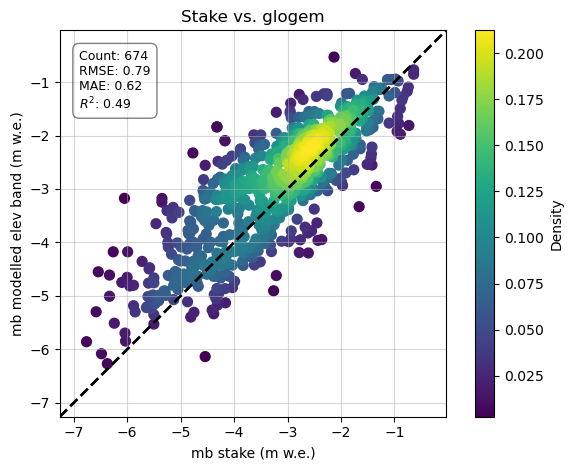

In [34]:
# TEST PLOT
plot_point_modelled(df_test_summer, 'glogem', 1980, 2019)

## Get ML-model predictions

In [35]:
# Model trained on cluster using up to 0.2 for learning rate. 
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
#with open('Training_cluster/2024-07-10_20-37-03/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using extended grid search (after implementing custom loss funciton performance improvement)
# param_ranges = {'max_depth': [4, 5, 6, 7, 8], # Depth of tree
#                'n_estimators': [200, 300, 400, 500, 600, 700], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2, 0.25], #[0,1]
with open('Training_cluster/2024-08-06_12-07-32/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

best_model = clf_loaded.best_estimator_

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


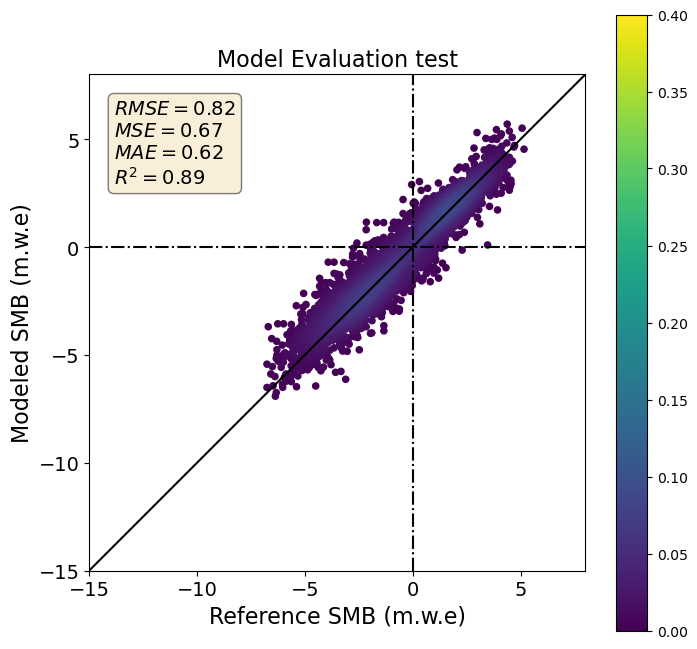

In [36]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

In [37]:
def get_prediction_per_season_test(X_test, y_test, best_model, months=12):

    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test[:,-2] == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    return y_test_crop, y_pred_crop

In [38]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
#plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

In [39]:
df_test_winter['mb_ML'] = y_pred_winter_agg


In [40]:
df_test_winter

BREID  year  altitude_diff  altitude  altitude_climate  balance  \
0      54.0  2013    -129.772081     471.0        341.227919     1.32   
1      54.0  2014     -97.772081     439.0        341.227919     1.68   
2      54.0  2015    -102.772081     444.0        341.227919     0.76   
3      54.0  2016    -102.772081     444.0        341.227919     0.78   
4      54.0  2017    -126.772081     468.0        341.227919     1.59   
..      ...   ...            ...       ...               ...      ...   
994  3141.0  2012    -160.580241    1078.0        917.419759     1.50   
995  3141.0  2013    -160.580241    1078.0        917.419759     1.14   
996  3141.0  2015    -161.580241    1079.0        917.419759     1.19   
997  3141.0  2016    -160.580241    1078.0        917.419759     1.72   
998  3141.0  2017    -160.580241    1078.0        917.419759     1.15   

       aspect     slope  n_months         t2m  ...           slhf  \
0    0.629597  0.278773       7.0  266.705911  ...   62438.500000   
1    0.585924  0.296590       7.0  267.740727  ...   65465.714286   
2    0.663261  0.302508       7.0  267.579795  ...   21334.214286   
3    0.663261  0.302508       7.0  267.811977  ...  102229.642857   
4    0.836757  0.309196       7.0  268.226903  ...   64772.571429   
..        ...       ...       ...         ...  ...            ...   
994  2.906044  0.131717       7.0  270.836827  ... -171713.642857   
995  2.906044  0.131717       7.0  267.233730  ... -123023.142857   
996  2.906044  0.131717       7.0  271.190260  ... -271647.642857   
997  2.906044  0.131717       7.0  270.403787  ... -251040.928571   
998  2.906044  0.131717       7.0  270.773926  ... -255928.142857   

             ssrd       fal           str        tp    ID mb_glogem   mb_oggm  \
0    3.477078e+06  0.749392 -2.148801e+06  0.003397  1258     1.226  1.860691   
1    3.052352e+06  0.758143 -2.145037e+06  0.003847  1258       NaN  1.774117   
2    3.186665e+06  0.750785 -2.258321e+06  0.002979  1258     1.055  1.406554   
3    3.540237e+06  0.771447 -2.084224e+06  0.003243  1258     0.773  1.752640   
4    3.494867e+06  0.679859 -2.391737e+06  0.003806  1258     1.073  1.887695   
..            ...       ...           ...       ...   ...       ...       ...   
994  4.804682e+06  0.683440 -1.769234e+06  0.010046  2969     1.795  3.112298   
995  5.492646e+06  0.711911 -2.165743e+06  0.006262  2969     1.639  2.114065   
996  4.664342e+06  0.653273 -1.837262e+06  0.011195  2969     1.681  2.945806   
997  5.058185e+06  0.655849 -1.987646e+06  0.009280  2969     2.123  2.917965   
998  4.882558e+06  0.674844 -1.963044e+06  0.008427  2969     1.972  2.442546   

     mb_pygem     mb_ML  
0    1.783696  1.377494  
1         NaN  2.074440  
2         NaN  1.800401  
3         NaN  1.986500  
4         NaN  1.447031  
..        ...       ...  
994       NaN  2.126732  
995       NaN  1.657523  
996       NaN  2.966729  
997       NaN  2.530411  
998       NaN  1.960515  

[999 rows x 21 columns]

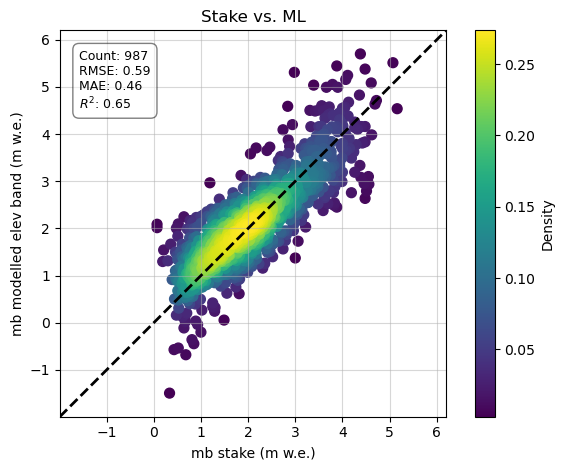

In [41]:
plot_point_modelled(df_test_winter, 'ML', 1960, 2020)

In [42]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
#plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

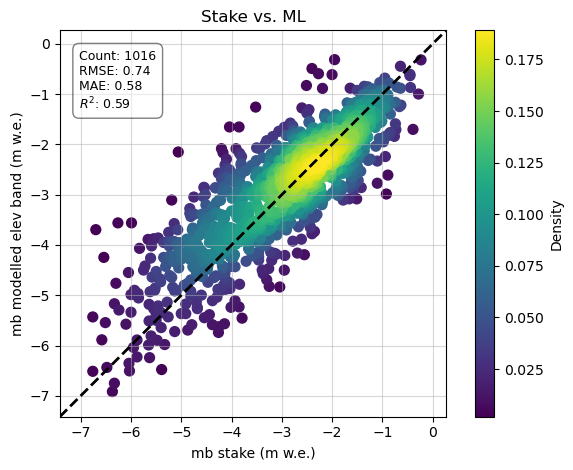

In [43]:
df_test_summer['mb_ML'] = y_pred_summer_agg
plot_point_modelled(df_test_summer, 'ML', 1960, 2020)

In [44]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
#plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

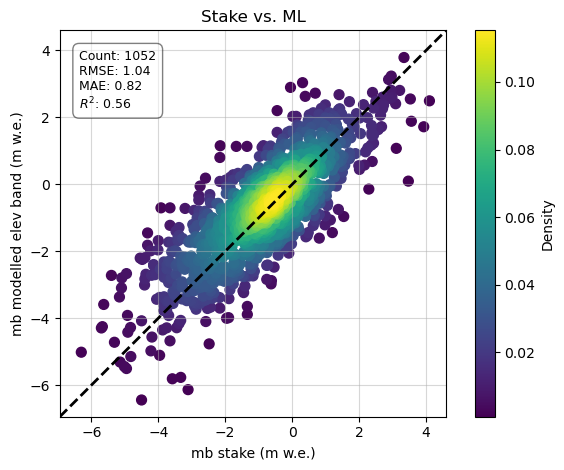

In [45]:
df_test_annual['mb_ML'] = y_pred_annual_agg
plot_point_modelled(df_test_annual, 'ML', 1960, 2020)

## Predict annual mass balance from seasonal mass balance, gives same results

In [46]:
# Predict annual mass balance from sum of seasonal mass balance

# Define the months for each group
winter_months = {'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr'}
summer_months = {'may', 'jun', 'jul', 'aug', 'sep'}

# Create a boolean mask for each group
winter_mask = np.isin(X_test_annual[:, -1], list(winter_months))
summer_mask = np.isin(X_test_annual[:, -1], list(summer_months))

# Create subsets using the masks
X_test_winter_sum = X_test_annual[winter_mask]
X_test_summer_sum = X_test_annual[summer_mask]

# Modify the second to last column for each subset
X_test_winter_sum[:, -2] = 7
X_test_summer_sum[:, -2] = 5

# Dummies
y_test_winter_sum = y_test_annual[winter_mask]
y_test_summer_sum = y_test_annual[summer_mask]
#y_test_winter_sum[:, -2] = 7
#y_test_summer_sum[:, -2] = 5

In [47]:
test_winter_sum_pred = best_model.predict(X_test_winter_sum)
test_summer_sum_pred = best_model.predict(X_test_summer_sum)

In [48]:
# Get test true values and predictions
y_test_winter_sum_mean, y_pred_winter_sum_agg = get_ytrue_y_pred_agg(y_test_winter_sum,test_winter_sum_pred,X_test_winter_sum)
y_test_summer_sum_mean, y_pred_summer_sum_agg = get_ytrue_y_pred_agg(y_test_summer_sum,test_summer_sum_pred,X_test_summer_sum)


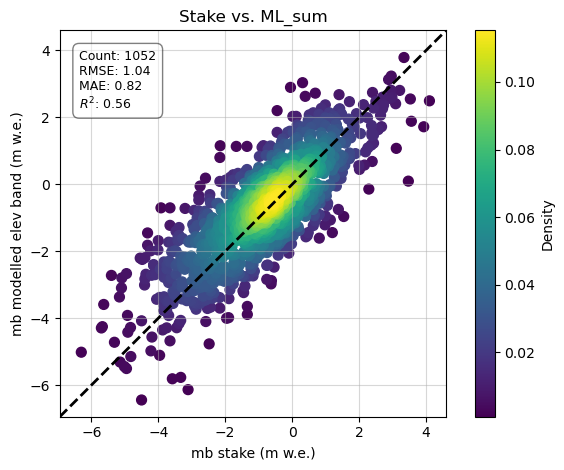

In [49]:
df_test_annual['mb_ML_sum'] = y_pred_winter_sum_agg + y_pred_summer_sum_agg
plot_point_modelled(df_test_annual, 'ML_sum', 1960, 2020)

In [50]:
df_test_annual[['mb_ML','mb_ML_sum']]

mb_ML  mb_ML_sum
0    -3.916289  -3.916289
1    -2.084774  -2.084774
2    -1.683928  -1.683928
3    -1.748840  -1.748840
4    -2.444991  -2.444991
...        ...        ...
1060 -2.088695  -2.088695
1061 -3.381490  -3.381490
1062 -0.904754  -0.904754
1063 -3.055314  -3.055314
1064 -3.425652  -3.425652

[1065 rows x 2 columns]

## Plot modelled point mass balance against observed point mass balance for all models

In [51]:
# Plot modelled and observed point mass balances

def plot_point_modelled_subplot(df, model, start_yr, end_yr, ax, min_val=None, max_val=None):
    """
    df : pd.Dataframe of point mb
    type : str, variable in ds; 'netto', 'summer' or 'winter'
    model : str, model name; 'glogem', 'oggm', 'pygem'
    ax: matplotlib Axes object for the subplot
    min_val: float, minimum value for xlim and ylim
    max_val: float, maximum value for xlim and ylim
    """

    df_clean_dropna = df.dropna(subset=['mb_'+model])
    df_clean = df_clean_dropna[(df_clean_dropna['year'] >= start_yr) & (df_clean_dropna['year'] <= end_yr)]

    y_data = df_clean['mb_'+model]
    x_data = df_clean['balance']
    
    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)

    df_with_density = pd.DataFrame({
        'x': x_data,
        'y': y_data,
        'z': z
    })

    df_with_density.sort_values('z', inplace=True)

    scatter = ax.scatter(df_with_density['x'], df_with_density['y'], c=df_with_density['z'], s=50, cmap='viridis')

    if min_val is None:
        min_val = min(x_data.min(), y_data.min()) - 0.5
    if max_val is None:
        max_val = max(x_data.max(), y_data.max()) + 0.5
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('mb stake (m w.e.)')
    ax.set_ylabel('mb modelled elev band (m w.e.)')
    ax.set_title('Stake vs. ' + model)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_data, x_data))
    mae = mean_absolute_error(y_data, x_data) 
    r2 = r2_score(y_data, x_data) 
    count = len(x_data)  # Count the number of data points
    
    stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    
    plt.colorbar(ax.collections[0], ax=ax, label='')
    ax.grid(alpha=0.5)

In [52]:
def plot_all_models(df, models, start_year, end_year, min_val=None, max_val=None):
    """
    df: DataFrame containing the data
    models: List of model names to plot
    start_year: Start year for filtering data
    end_year: End year for filtering data
    min_val: float, override for min value for xlim and ylim
    max_val: float, override for max value for xlim and ylim
    """
    
    # Create a figure with 4 subplots in one row
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), squeeze=False)
    
    for i, model_name in enumerate(models):
        ax = axs[0, i]  # Access each subplot
        plot_point_modelled_subplot(df, model_name, start_year, end_year, ax, min_val=min_val, max_val=max_val)
        
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

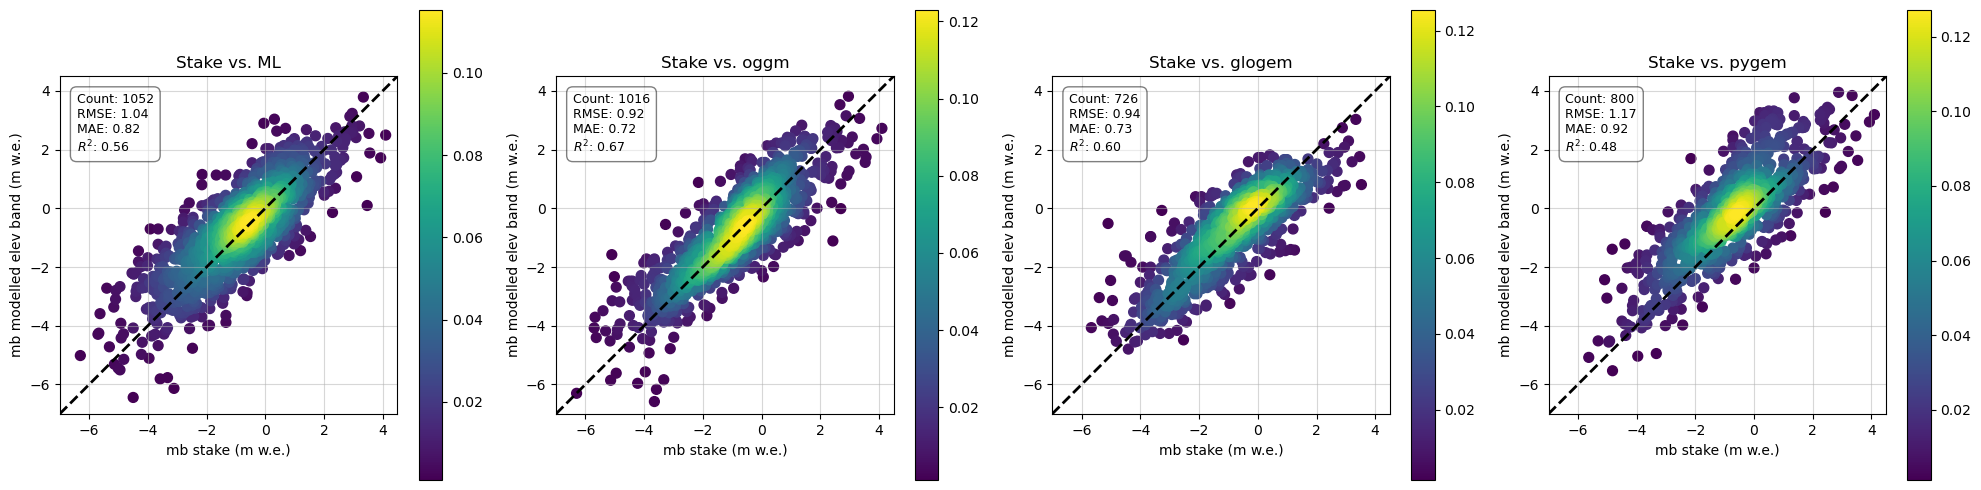

In [53]:
# List of model names
models = ['ML', 'oggm', 'glogem', 'pygem']

plot_all_models(df_test_annual, models, 1960, 2020, min_val=-7, max_val=4.5)

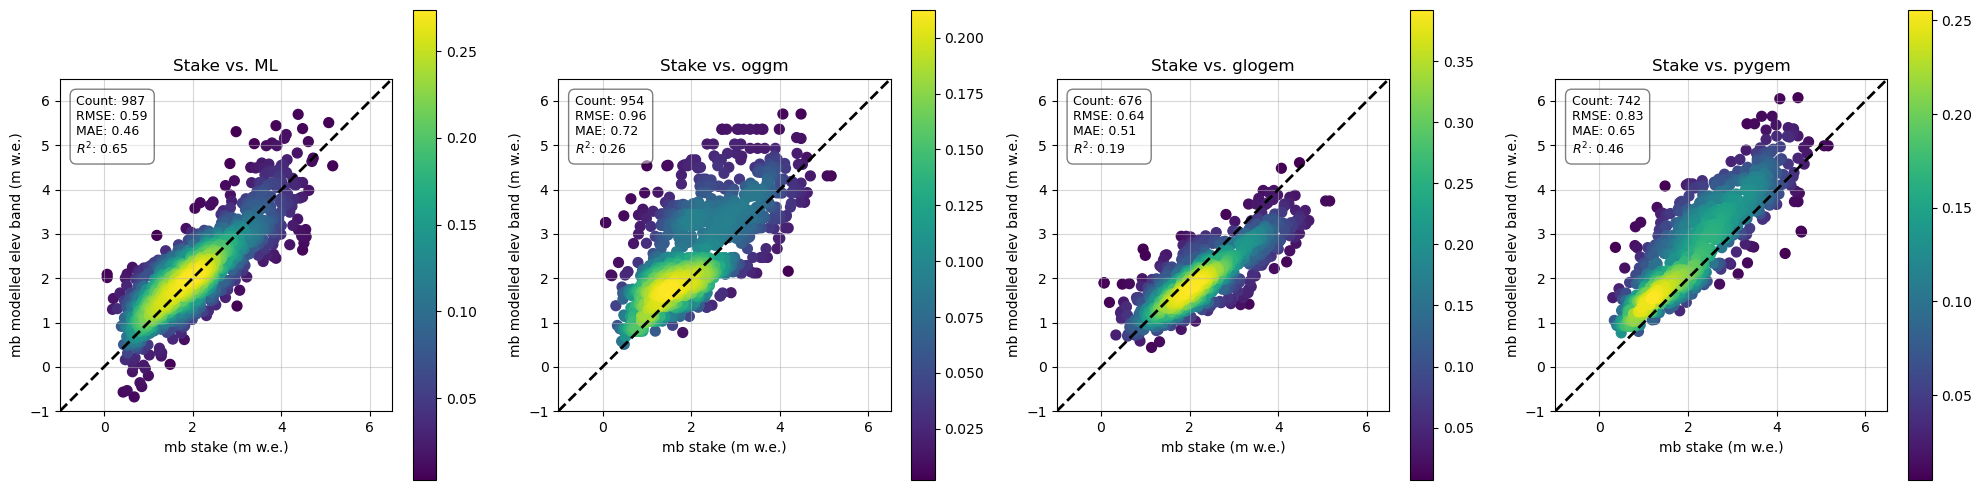

In [55]:
plot_all_models(df_test_winter, models, 1960, 2020, min_val=-1, max_val=6.5)

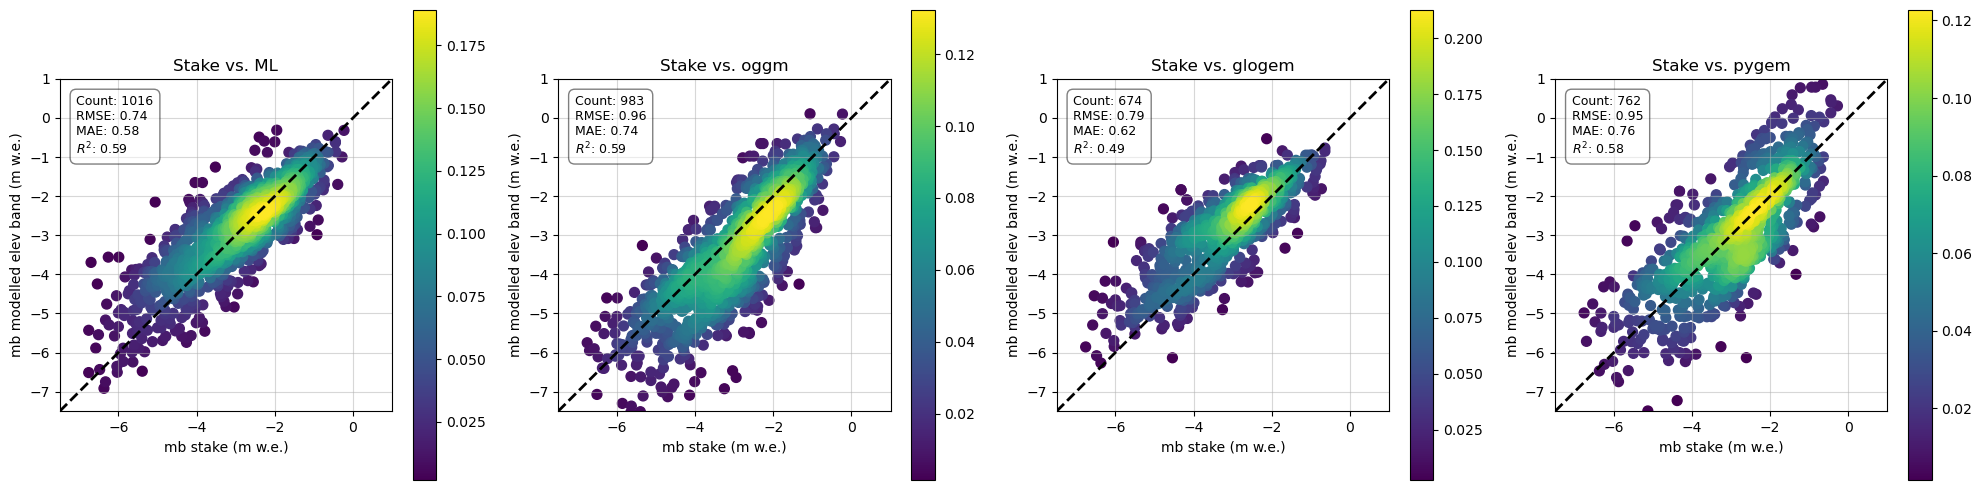

In [56]:
plot_all_models(df_test_summer, models, 1960, 2020, min_val=-7.5, max_val=1)

In [57]:
# Filter dataframe with model predictions such that only common values that are not nan are evaluated
# Define the columns to check for NaN values
model_columns = ['mb_ML', 'mb_oggm', 'mb_pygem', 'mb_glogem']

# Filter the DataFrame to select rows where none of the specified columns have NaN values
df_test_annual_nonan = df_test_annual.dropna(subset=model_columns).reset_index(drop=True)
df_test_winter_nonan = df_test_winter.dropna(subset=model_columns).reset_index(drop=True)
df_test_summer_nonan = df_test_summer.dropna(subset=model_columns).reset_index(drop=True)


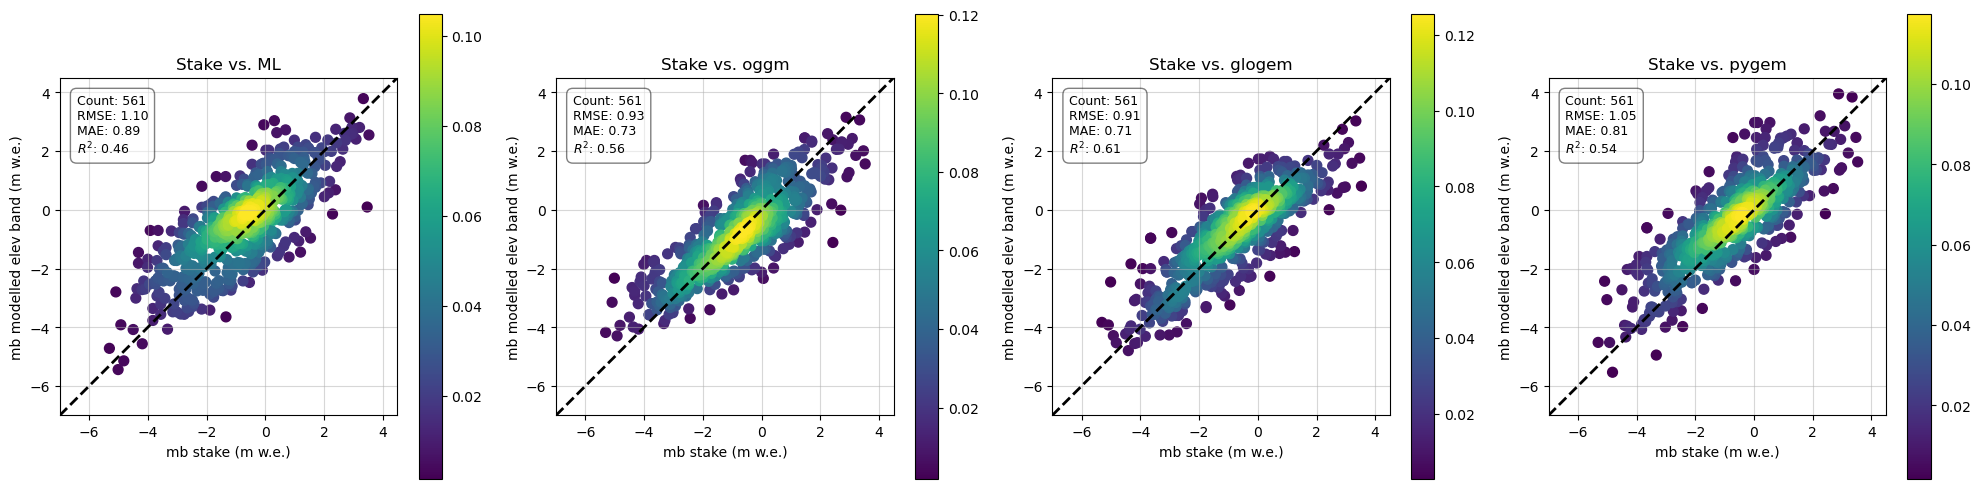

In [58]:
# Annual mb with only common points
plot_all_models(df_test_annual_nonan, models, 1960, 2020, min_val=-7, max_val=4.5)

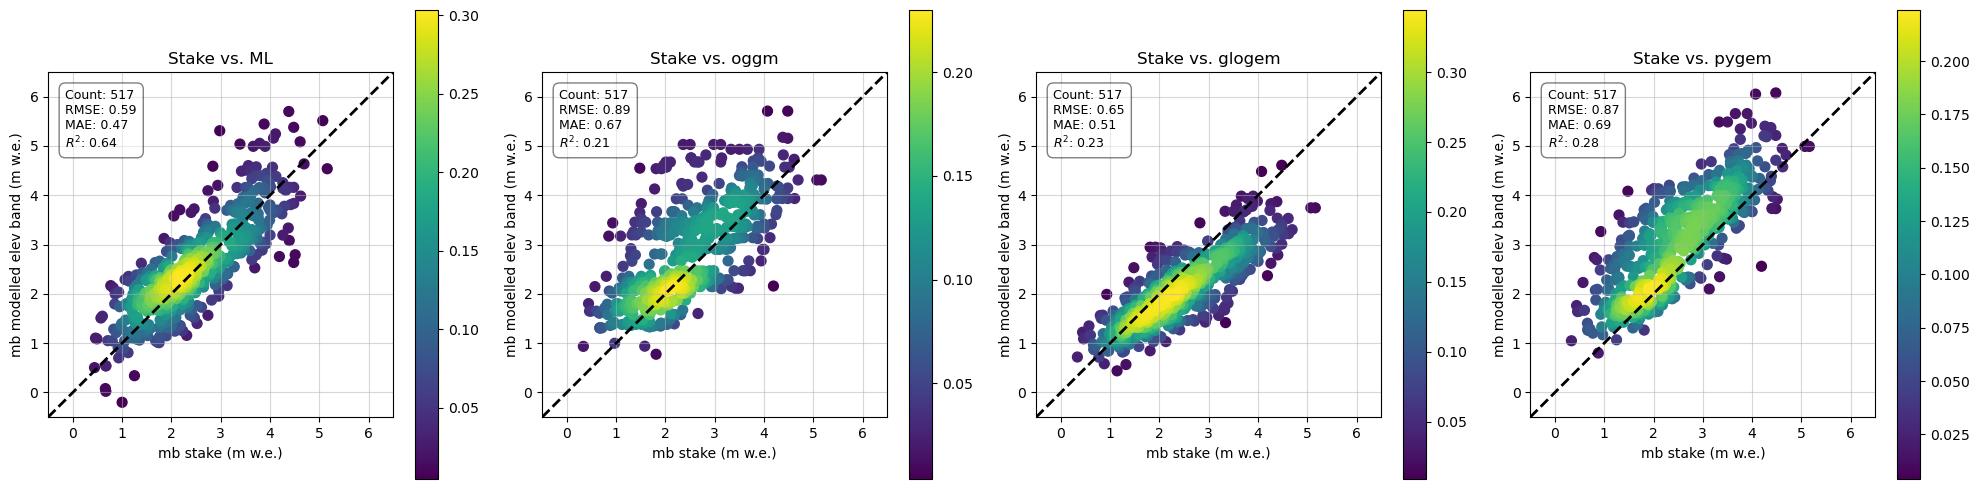

In [59]:
# Winter mb with only common points
plot_all_models(df_test_winter_nonan, models, 1960, 2020, min_val=-0.5, max_val=6.5)

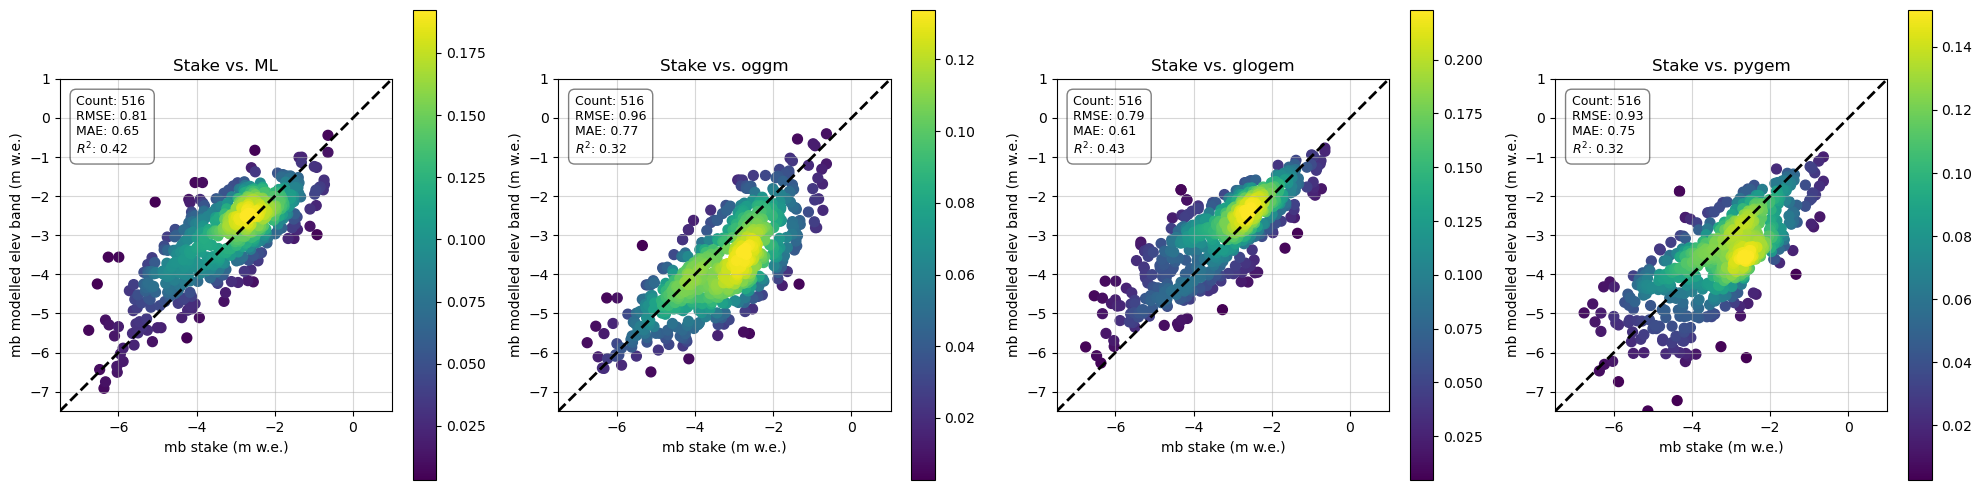

In [60]:
plot_all_models(df_test_summer_nonan, models, 1960, 2020, min_val=-7.5, max_val=1)

## Error distributions for point mass balances

In [61]:
# Explore error distribution by BREID, year, and altitude
features_to_explore = ['BREID', 'year', 'altitude']

# Function to group by feature and calculate error statistics
def explore_error_distribution(df, feature):
    grouped = df.groupby(feature).agg({
        'error_ML': ['mean', 'std'],
        'error_oggm': ['mean', 'std'],
        'error_pygem': ['mean', 'std'],
        'error_glogem': ['mean', 'std']
    })
    print(f"\nError distribution grouped by {feature}:")
    print(grouped)

In [62]:
# Function to create box plots
def create_box_plots(df, feature):
    sns.set(style="whitegrid")

    plt.figure(figsize=(14, 8))
    sns.boxplot(x=feature, y='value', hue='variable', 
                data=pd.melt(df, id_vars=[feature], value_vars=['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem']))
    plt.title(f'Error Distribution by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Abs. Error')
    plt.xticks(rotation=90)
    plt.legend(title='Model')
    plt.show()

# Function to create violin plots
def create_violin_plots(df, feature):
    sns.set(style="whitegrid")

    plt.figure(figsize=(12, 8))
    sns.violinplot(x=feature, y='value', hue='variable', 
                   data=pd.melt(df, id_vars=[feature], value_vars=['error_ML', 'error_oggm', 'error_pygem', 'error_glogem']), split=False)
    plt.title(f'Error Distribution by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Error')
    plt.legend(title='Model')
    plt.show()

# Function to create histograms
def create_histograms(df):
    sns.set(style="whitegrid")

    df_melted = pd.melt(df, var_name='Model', value_name='Error', value_vars=['error_ML', 'error_oggm', 'error_pygem', 'error_glogem'])
    plt.figure(figsize=(14, 10))
    sns.histplot(data=df_melted, x='Error', hue='Model', kde=True, element='step')
    plt.title('Error Histogram for Each Model')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

def plot_mean_absolute_error_by_year(df, year_col, error_cols, title='Mean Absolute Error by Year for Each Model'):
    """
    Plots the mean absolute error for each model per year with lines connecting the points.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    year_col (str): Column name for the year data.
    error_cols (list of str): List of column names for the absolute error values.
    title (str): Title of the plot. Default is 'Mean Absolute Error by Year for Each Model'.

    """
    # Calculating mean absolute error per year for each model
    mean_abs_error = df.groupby(year_col)[error_cols].mean().reset_index()

    # Melt the DataFrame to long-format for seaborn
    mean_abs_error_melted = pd.melt(mean_abs_error, id_vars=year_col, value_name='MeanAbsError', var_name='Model')

    # Set up the visualization style
    sns.set(style="whitegrid")

    # Plot mean absolute error for each model by year with lines connecting points
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=mean_abs_error_melted, x=year_col, y='MeanAbsError', hue='Model', marker='o')
    plt.title(title)
    plt.xlabel(year_col.capitalize())
    plt.ylabel('Mean Abs. Error')
    plt.xticks(rotation=90)
    plt.legend(title='Model')
    plt.show()

def plot_error_distribution_by_altitude_interval(df, altitude_col, error_cols, interval=100, title='Error Distribution by Altitude Intervals'):
    """
    Plots the error distribution for altitude intervals as boxplots.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    altitude_col (str): Column name for the altitude data.
    error_cols (list of str): List of column names for the error values.
    interval (int): Interval for binning altitude values. Default is 50.
    title (str): Title of the plot. Default is 'Error Distribution by Altitude Intervals'.
    """
    sns.set(style="whitegrid")

    # Bin the altitude values into intervals
    df['altitude_interval'] = pd.cut(df[altitude_col], bins=range(int(df[altitude_col].min()), int(df[altitude_col].max()) + interval, interval))

    # Melt the DataFrame to long-format for seaborn
    melted_df = pd.melt(df, id_vars=['altitude_interval'], value_vars=error_cols, var_name='Model', value_name='Error')

    # Set up the visualization style
    sns.set(style="whitegrid")

    # Plot error distribution for each altitude interval using boxplots
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='altitude_interval', y='Error', hue='Model', data=melted_df)
    plt.title(title)
    plt.xlabel('Altitude Interval (m)')
    plt.ylabel('Error')
    plt.xticks(rotation=90)
    plt.legend(title='Model')
    plt.show()


### Annual mb, only common points

In [63]:
# Calculate errors for each model
df_test_annual_nonan['error_ML'] = df_test_annual_nonan['mb_ML'] - df_test_annual_nonan['balance']
df_test_annual_nonan['error_oggm'] = df_test_annual_nonan['mb_oggm'] - df_test_annual_nonan['balance']
df_test_annual_nonan['error_pygem'] = df_test_annual_nonan['mb_pygem'] - df_test_annual_nonan['balance']
df_test_annual_nonan['error_glogem'] = df_test_annual_nonan['mb_glogem'] - df_test_annual_nonan['balance']

df_test_annual_nonan['abs_error_ML'] = df_test_annual_nonan['error_ML'].abs()
df_test_annual_nonan['abs_error_oggm'] = df_test_annual_nonan['error_oggm'].abs()
df_test_annual_nonan['abs_error_pygem'] = df_test_annual_nonan['error_pygem'].abs()

df_test_annual_nonan['abs_error_glogem'] = df_test_annual_nonan['error_glogem'].abs()

# Explore distributions for each feature
for feature in features_to_explore:
    explore_error_distribution(df_test_annual_nonan, feature)


Error distribution grouped by BREID:
        error_ML           error_oggm           error_pygem            \
            mean       std       mean       std        mean       std   
BREID                                                                   
54.0    0.052552  1.031396   0.262671  0.620582    0.263940  0.626695   
941.0  -0.121242  0.983496  -0.244419  0.610028    0.007108  0.698715   
1135.0 -0.621946  1.202547   0.000155  0.882140    0.531969  0.973678   
1280.0 -0.676272  0.594880   0.645214  0.770358    0.795955  0.754679   
2085.0  0.889400  0.929511   0.386198  0.849075    1.061762  0.862616   
2478.0  0.383031  0.646541  -0.040393  0.765725    0.313756  0.754238   
2768.0 -0.378720  1.094306   1.022574  0.773898    0.873521  1.235273   
3133.0 -0.274119  0.852107  -1.167754  1.281850   -0.867274  1.312104   
3137.0  0.479256  0.864442  -0.390210  0.685203   -0.125978  0.725154   
3138.0  0.109844  0.602295  -0.937111  0.689059    0.300205  0.730234   
3141.0  0.612

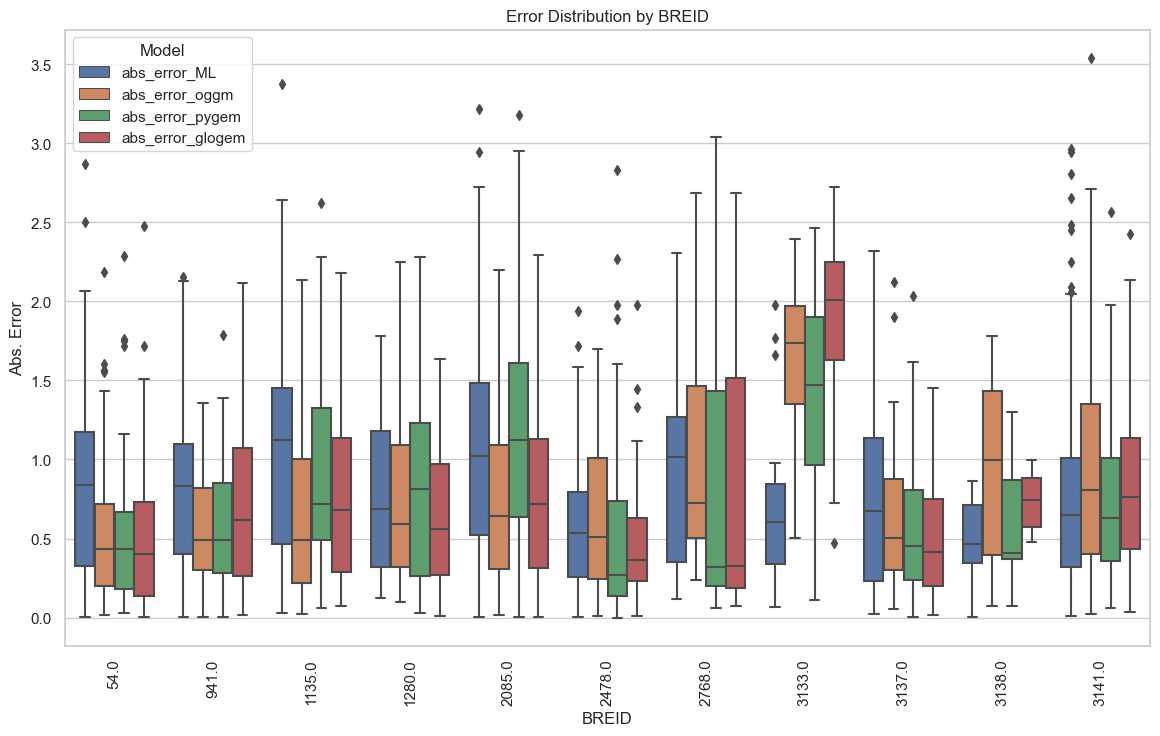

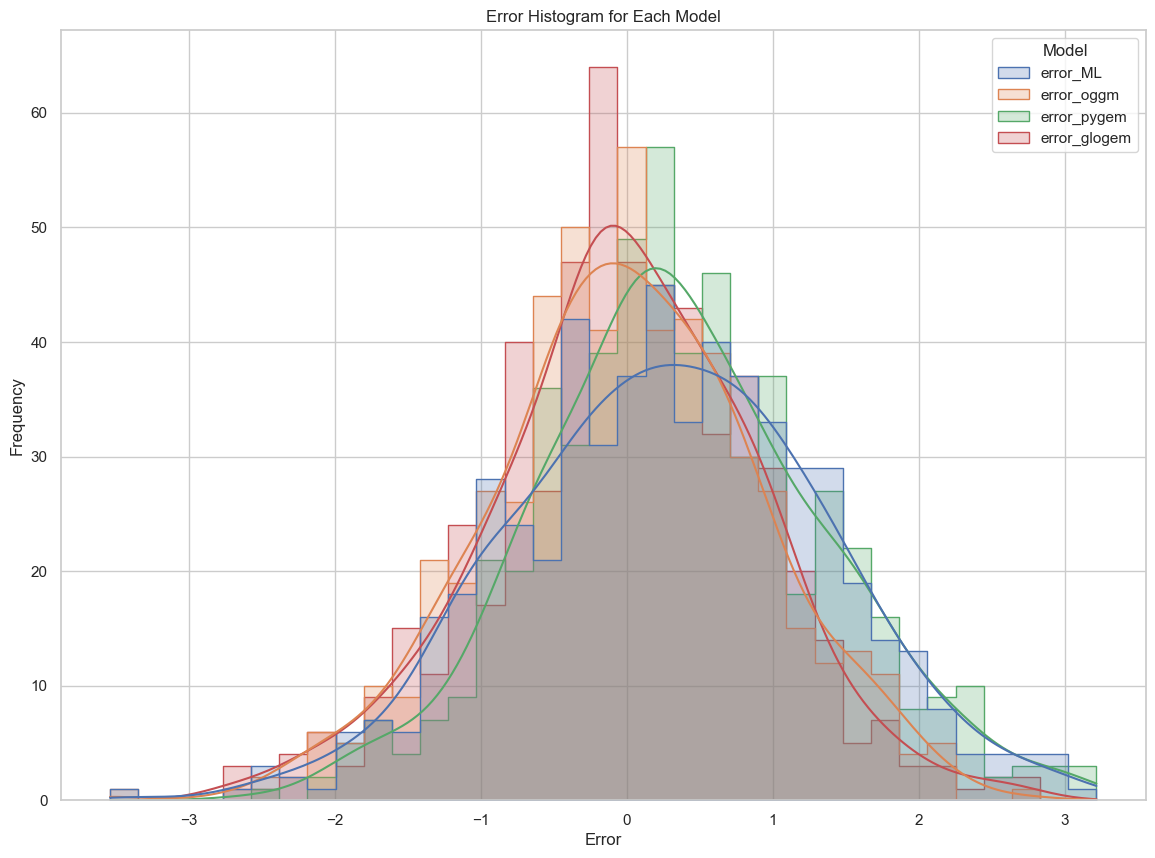

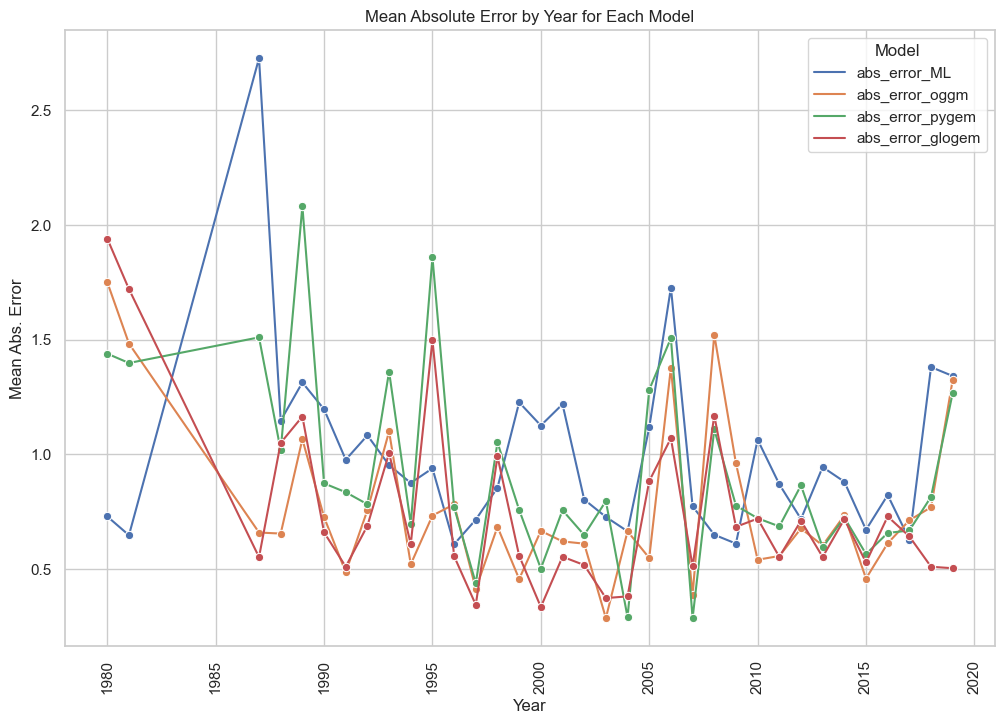

In [64]:
# Annual mass balance, only common points

create_box_plots(df_test_annual_nonan, 'BREID')

create_histograms(df_test_annual_nonan)

plot_mean_absolute_error_by_year(df_test_annual_nonan, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

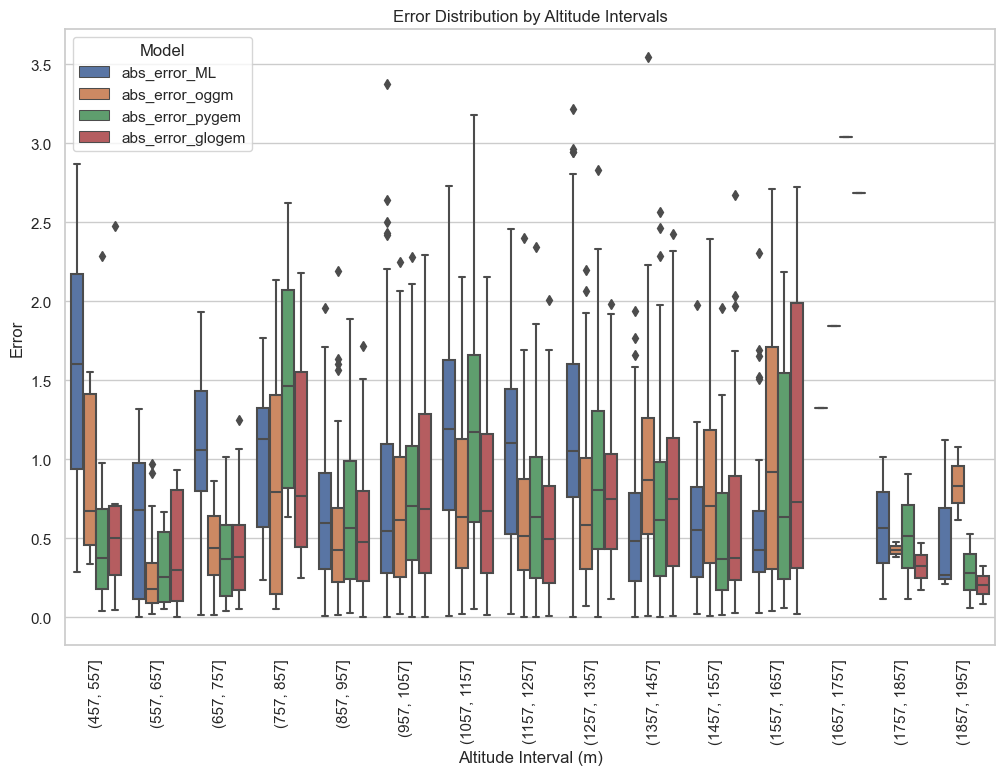

In [65]:
#plot_error_distribution_by_altitude_interval(df_test_annual_nonan, 'altitude', ['error_ML', 'error_oggm', 'error_pygem', 'error_glogem'], interval=100)

plot_error_distribution_by_altitude_interval(df_test_annual_nonan, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Summer mb, only common points

In [66]:
# Calculate errors for each model
df_test_summer_nonan['error_ML'] = df_test_summer_nonan['mb_ML'] - df_test_summer_nonan['balance']
df_test_summer_nonan['error_oggm'] = df_test_summer_nonan['mb_oggm'] - df_test_summer_nonan['balance']
df_test_summer_nonan['error_pygem'] = df_test_summer_nonan['mb_pygem'] - df_test_summer_nonan['balance']
df_test_summer_nonan['error_glogem'] = df_test_summer_nonan['mb_glogem'] - df_test_summer_nonan['balance']

df_test_summer_nonan['abs_error_ML'] = df_test_summer_nonan['error_ML'].abs()
df_test_summer_nonan['abs_error_oggm'] = df_test_summer_nonan['error_oggm'].abs()
df_test_summer_nonan['abs_error_pygem'] = df_test_summer_nonan['error_pygem'].abs()
df_test_summer_nonan['abs_error_glogem'] = df_test_summer_nonan['error_glogem'].abs()

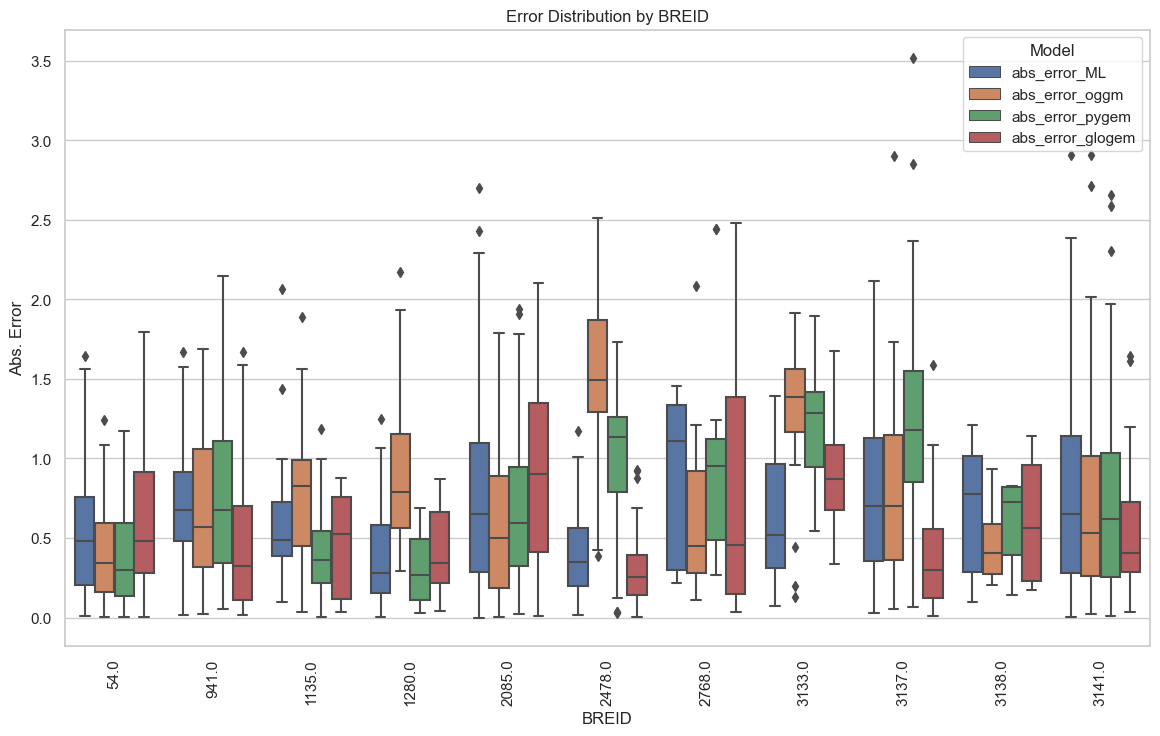

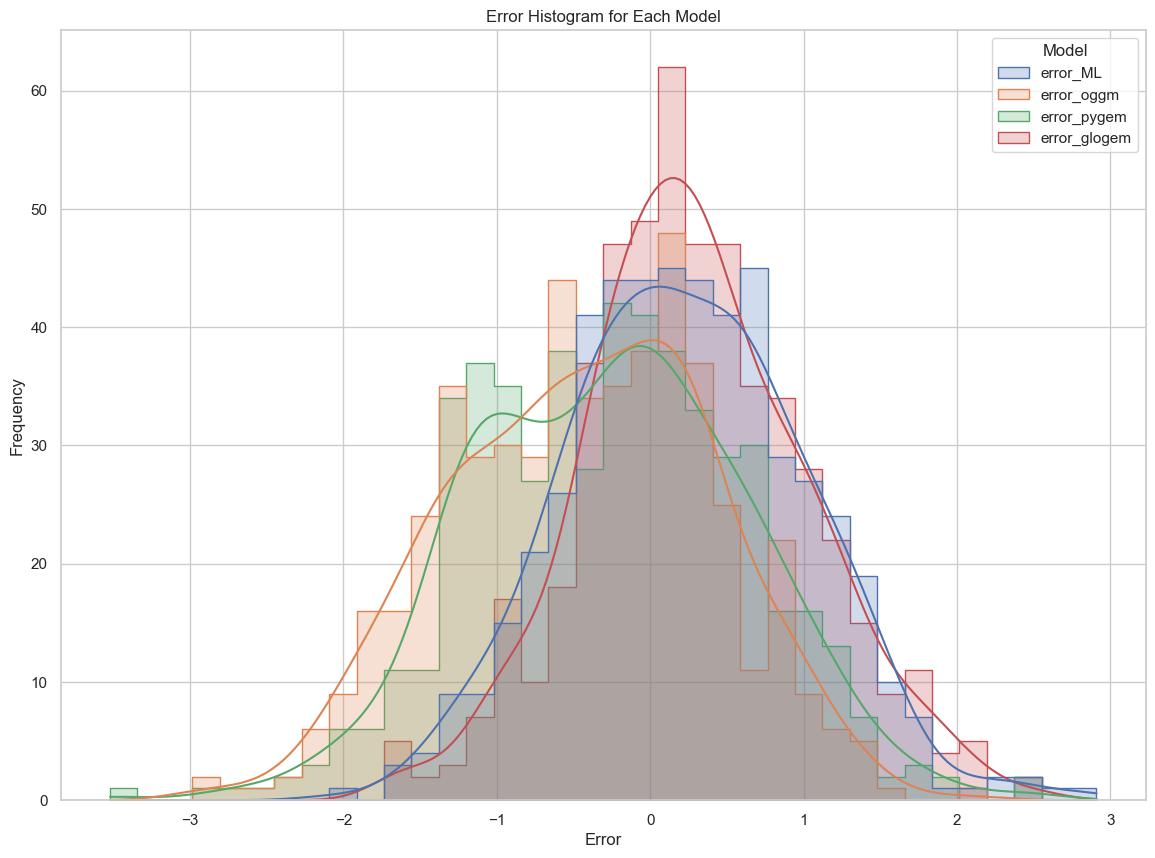

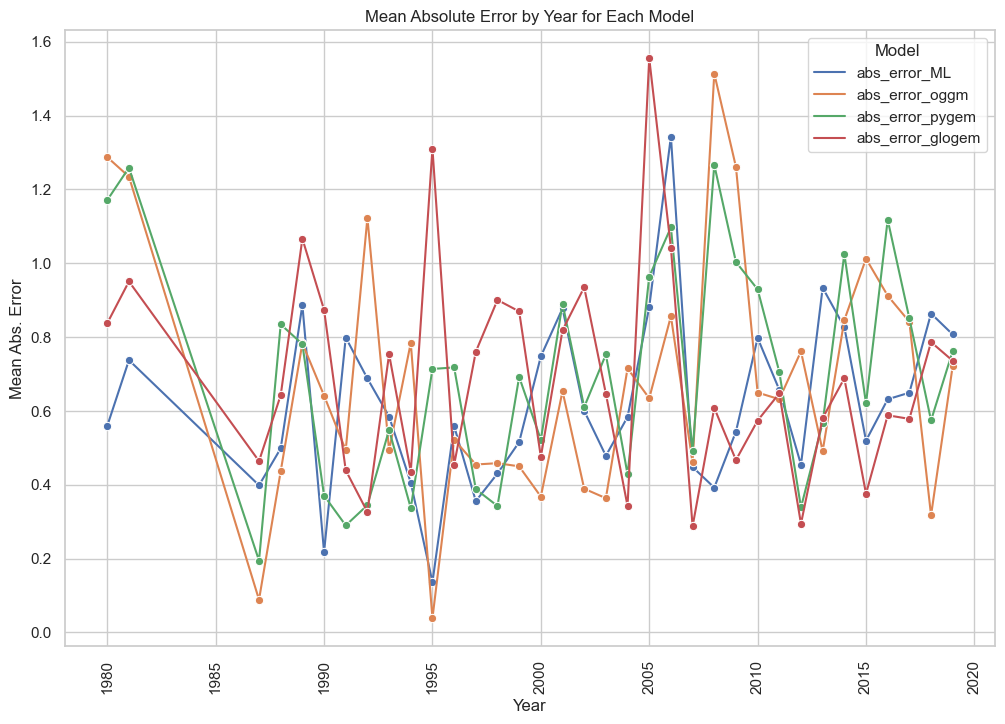

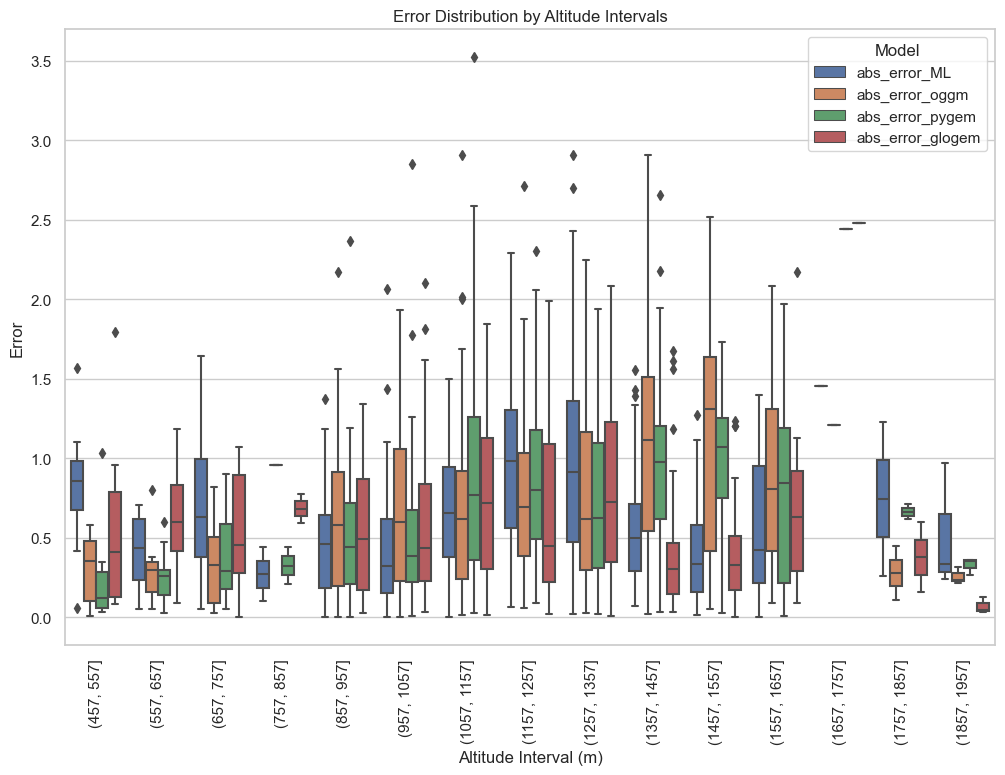

In [67]:
# Summer mass balance, only common points

create_box_plots(df_test_summer_nonan, 'BREID')

create_histograms(df_test_summer_nonan)

plot_mean_absolute_error_by_year(df_test_summer_nonan, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_summer_nonan, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Winter mb, only common points

In [68]:
# Calculate errors for each model
df_test_winter_nonan['error_ML'] = df_test_winter_nonan['mb_ML'] - df_test_winter_nonan['balance']
df_test_winter_nonan['error_oggm'] = df_test_winter_nonan['mb_oggm'] - df_test_winter_nonan['balance']
df_test_winter_nonan['error_pygem'] = df_test_winter_nonan['mb_pygem'] - df_test_winter_nonan['balance']
df_test_winter_nonan['error_glogem'] = df_test_winter_nonan['mb_glogem'] - df_test_winter_nonan['balance']

df_test_winter_nonan['abs_error_ML'] = df_test_winter_nonan['error_ML'].abs()
df_test_winter_nonan['abs_error_oggm'] = df_test_winter_nonan['error_oggm'].abs()
df_test_winter_nonan['abs_error_pygem'] = df_test_winter_nonan['error_pygem'].abs()
df_test_winter_nonan['abs_error_glogem'] = df_test_winter_nonan['error_glogem'].abs()

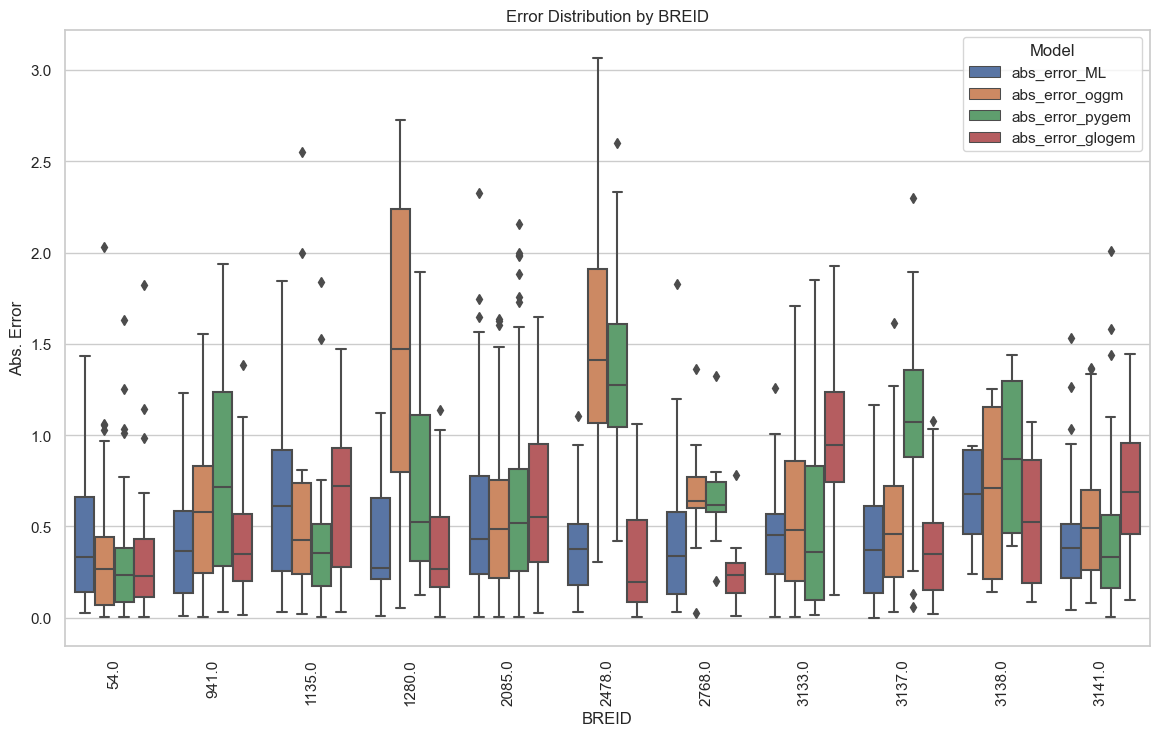

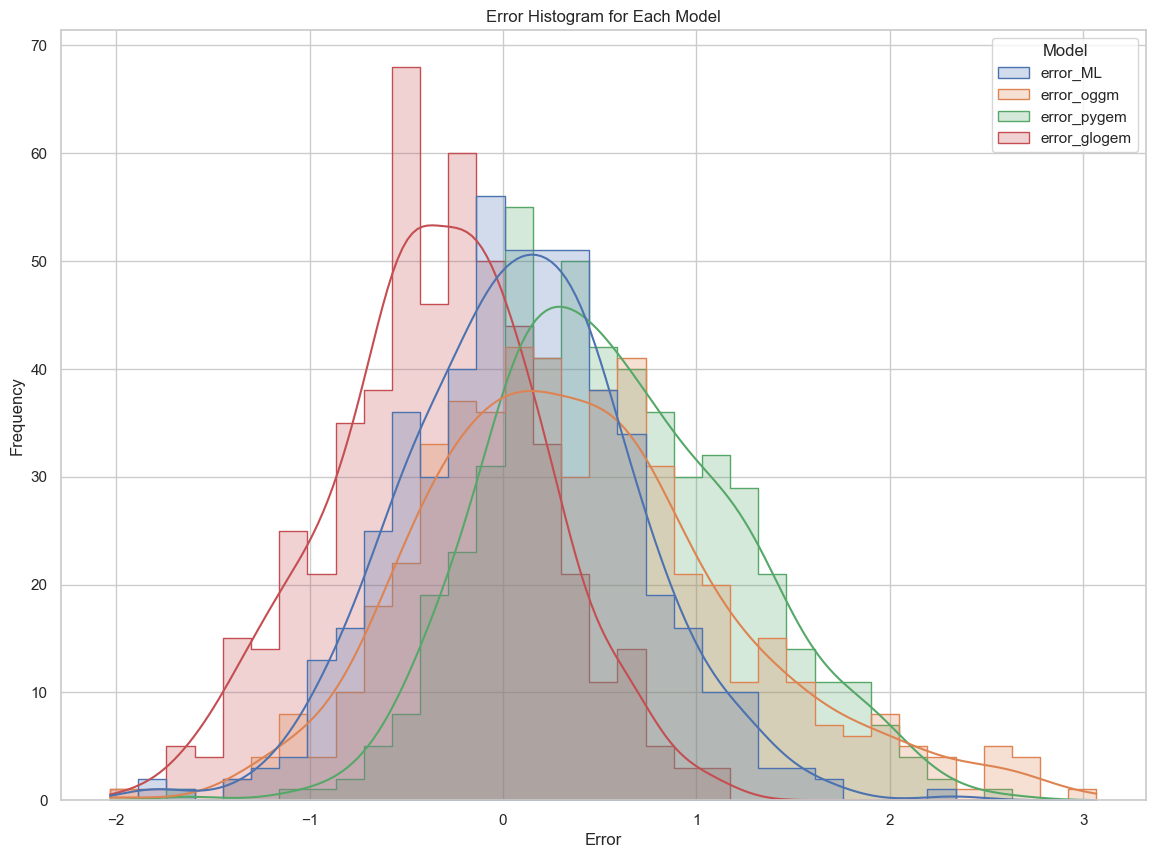

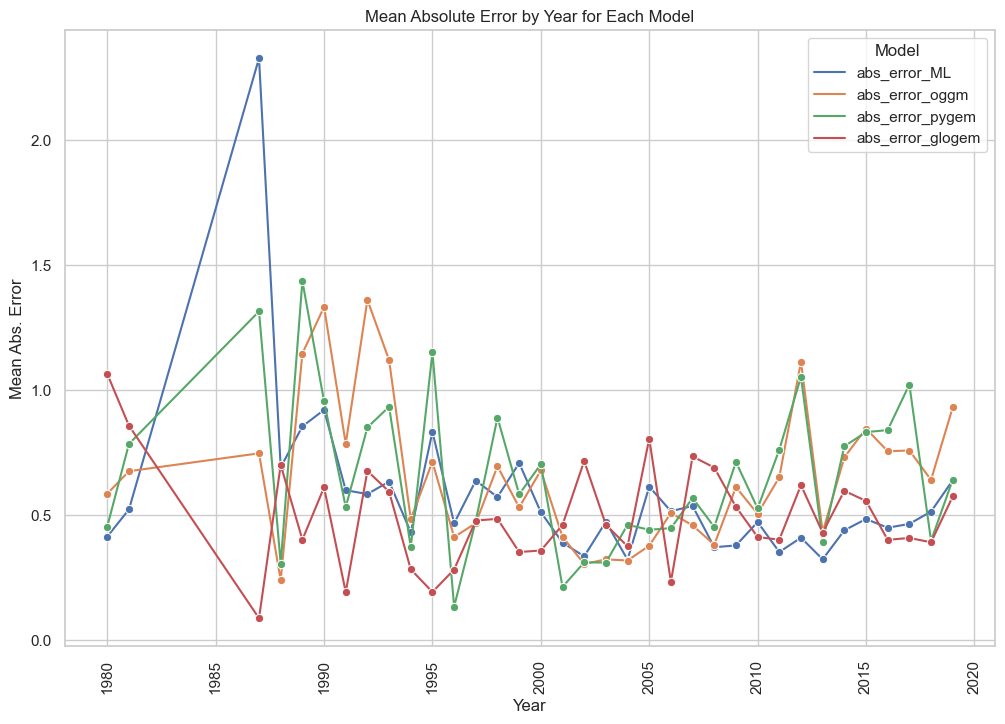

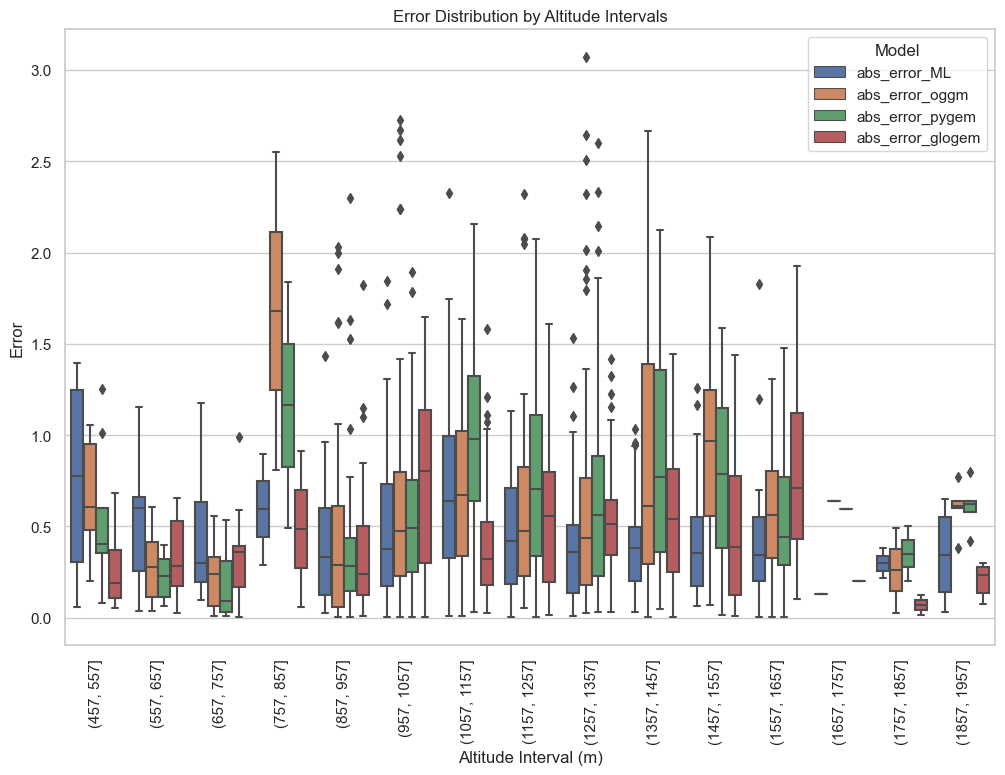

In [69]:
# Winter mass balance, only common points

create_box_plots(df_test_winter_nonan, 'BREID')

create_histograms(df_test_winter_nonan)

plot_mean_absolute_error_by_year(df_test_winter_nonan, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_winter_nonan, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Annual mb, all points

In [242]:
# Calculate errors for each model
df_test_annual['error_ML'] = df_test_annual['mb_ML'] - df_test_annual['balance']
df_test_annual['error_oggm'] = df_test_annual['mb_oggm'] - df_test_annual['balance']
df_test_annual['error_pygem'] = df_test_annual['mb_pygem'] - df_test_annual['balance']
df_test_annual['error_glogem'] = df_test_annual['mb_glogem'] - df_test_annual['balance']

df_test_annual['abs_error_ML'] = df_test_annual['error_ML'].abs()
df_test_annual['abs_error_oggm'] = df_test_annual['error_oggm'].abs()
df_test_annual['abs_error_pygem'] = df_test_annual['error_pygem'].abs()
df_test_annual['abs_error_glogem'] = df_test_annual['error_glogem'].abs()

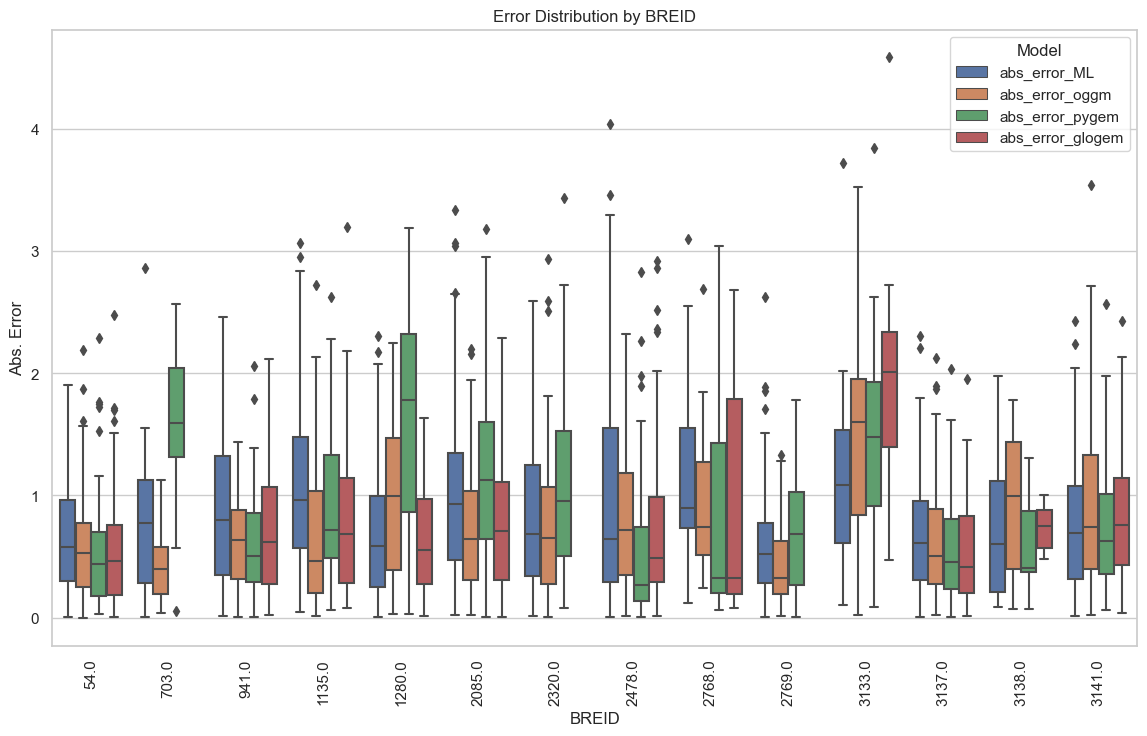

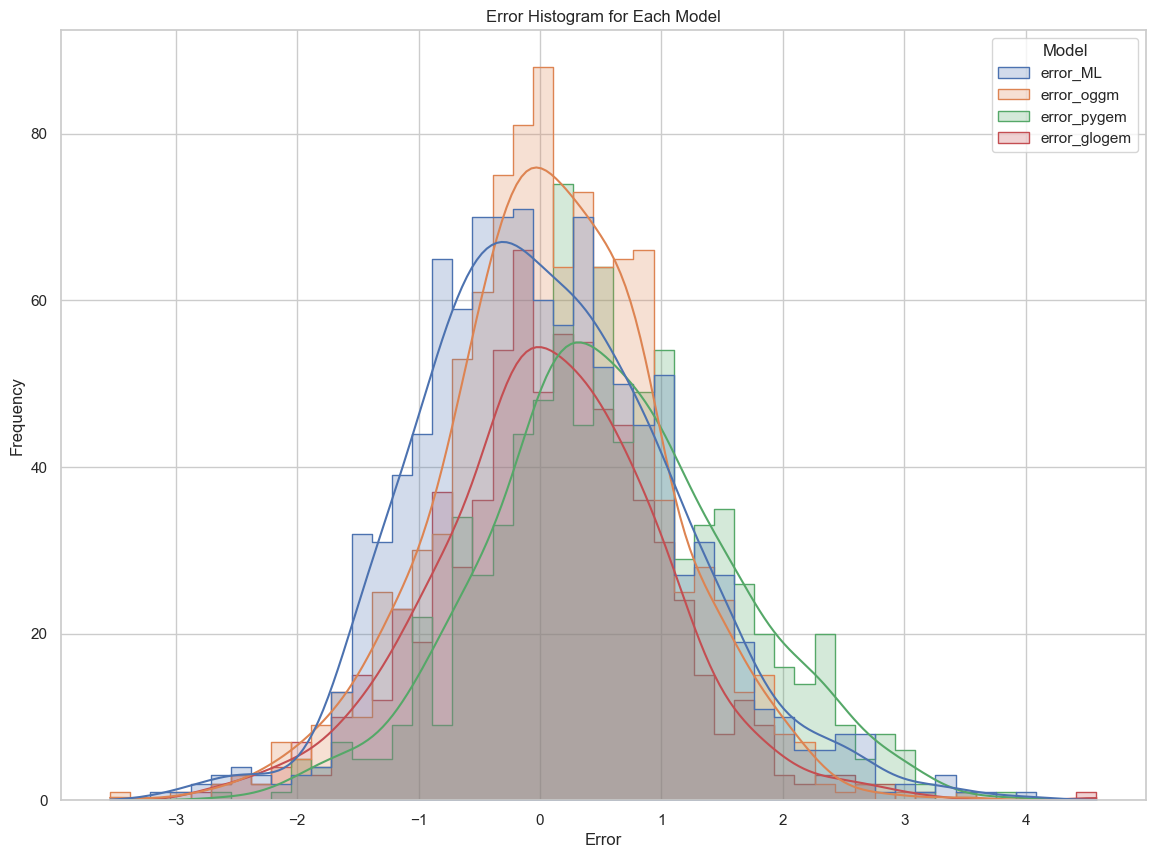

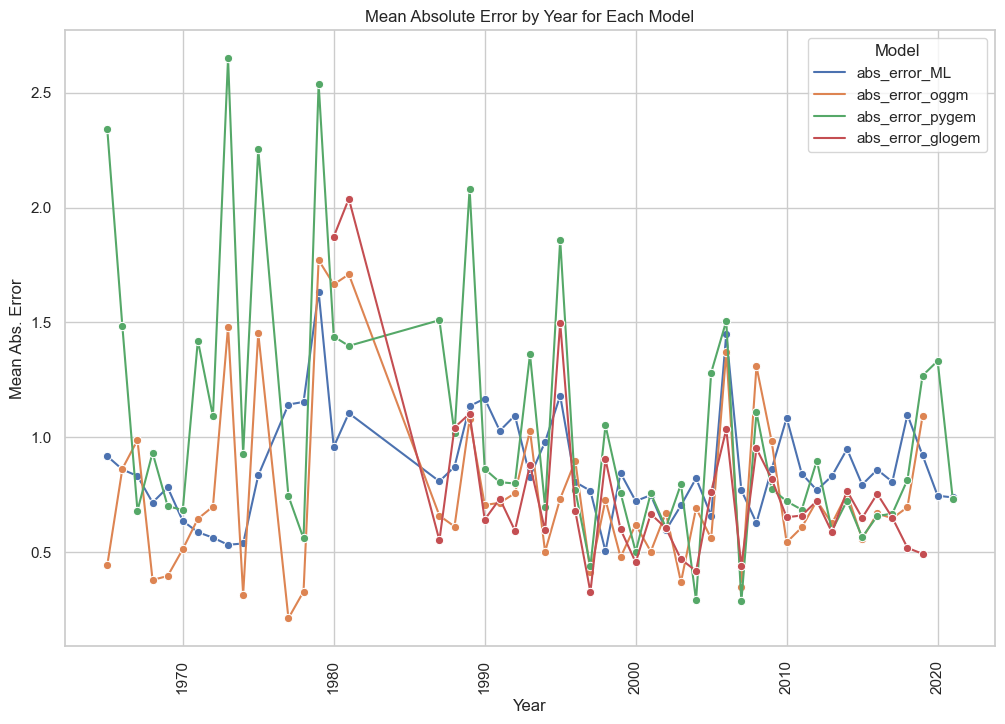

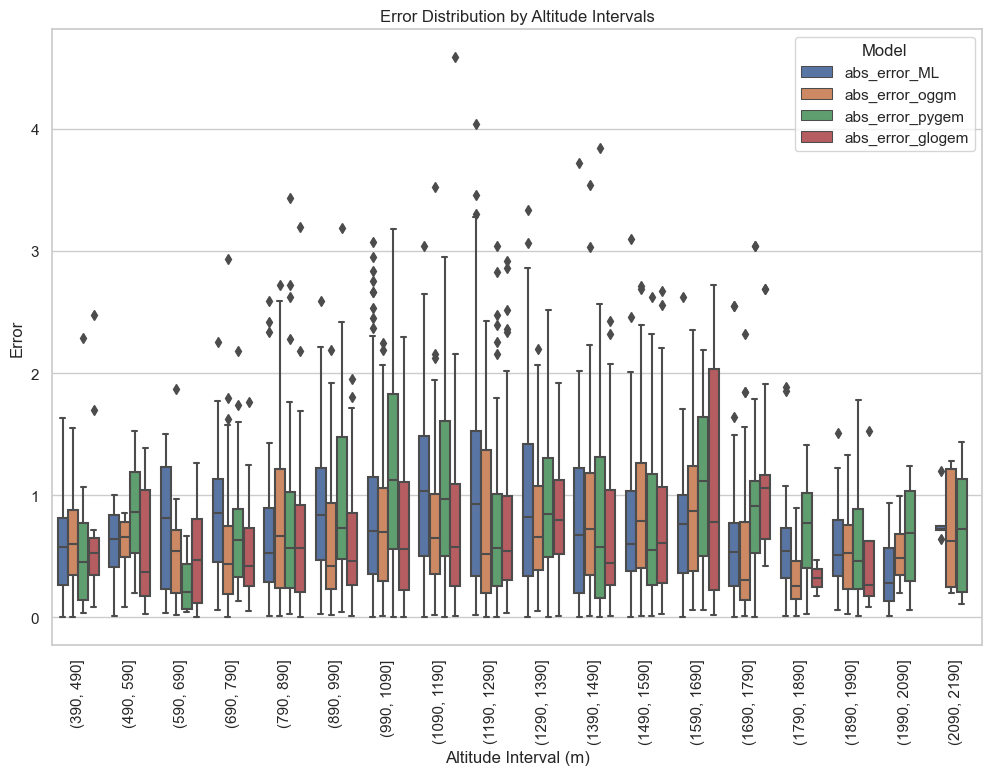

In [243]:
# Annual mass balance, all points

create_box_plots(df_test_annual, 'BREID')

create_histograms(df_test_annual)

plot_mean_absolute_error_by_year(df_test_annual, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_annual, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Summer mb, all points

In [244]:
# Calculate errors for each model
df_test_summer['error_ML'] = df_test_summer['mb_ML'] - df_test_summer['balance']
df_test_summer['error_oggm'] = df_test_summer['mb_oggm'] - df_test_summer['balance']
df_test_summer['error_pygem'] = df_test_summer['mb_pygem'] - df_test_summer['balance']
df_test_summer['error_glogem'] = df_test_summer['mb_glogem'] - df_test_summer['balance']

df_test_summer['abs_error_ML'] = df_test_summer['error_ML'].abs()
df_test_summer['abs_error_oggm'] = df_test_summer['error_oggm'].abs()
df_test_summer['abs_error_pygem'] = df_test_summer['error_pygem'].abs()
df_test_summer['abs_error_glogem'] = df_test_summer['error_glogem'].abs()

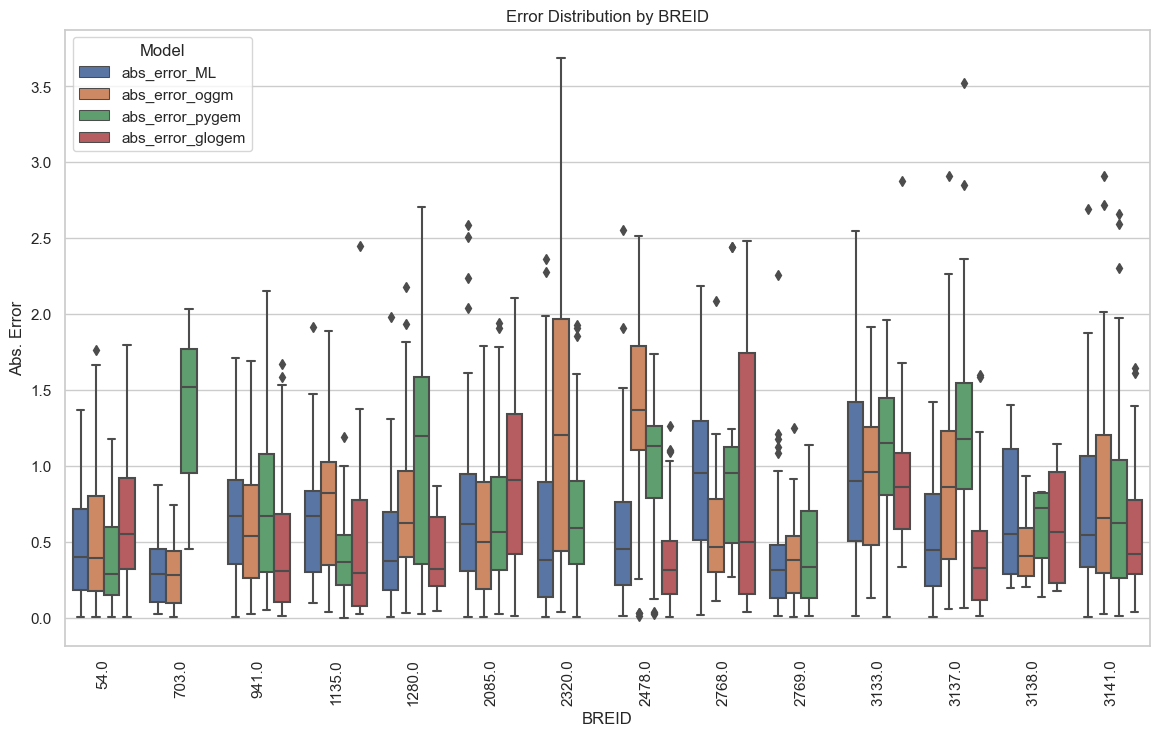

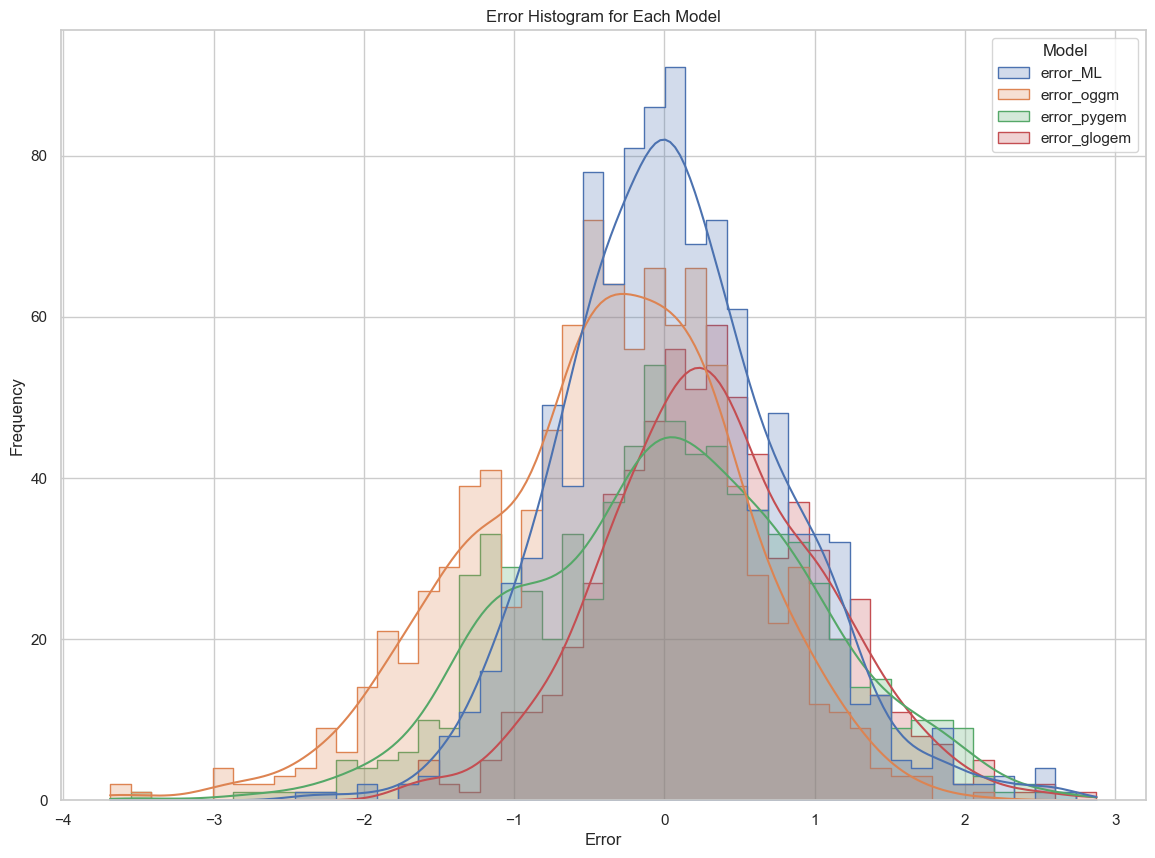

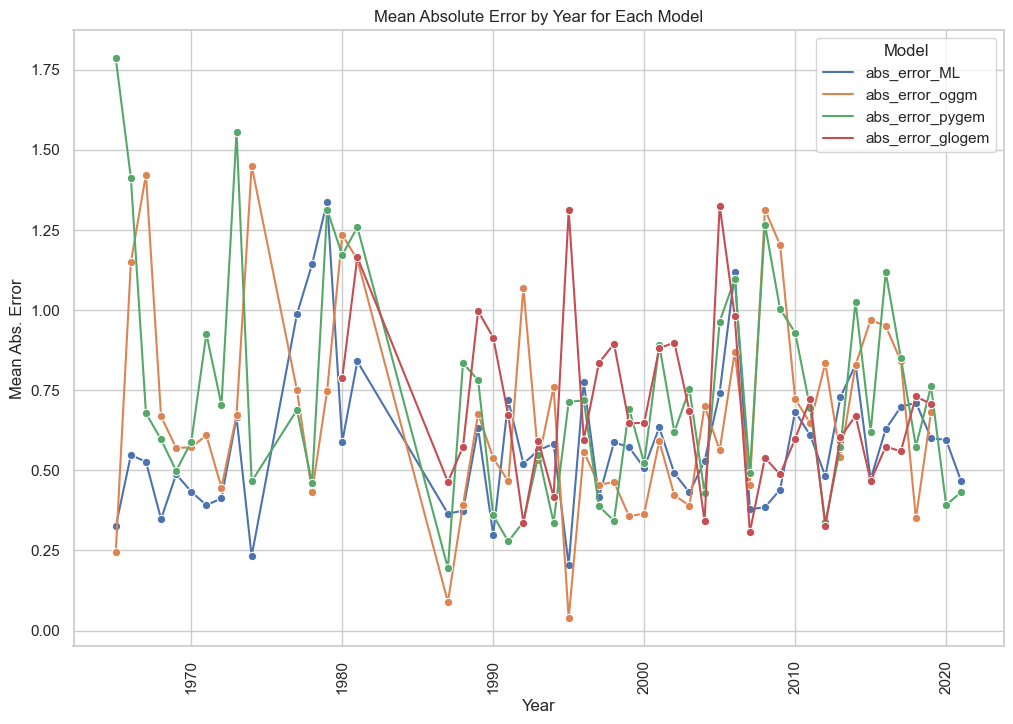

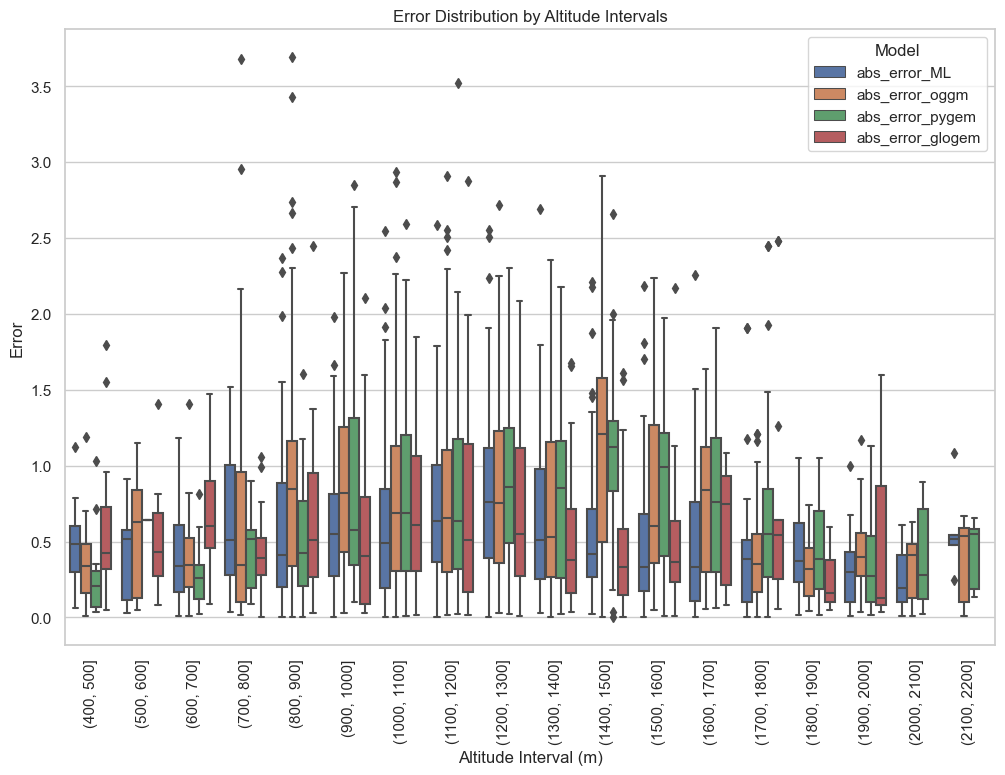

In [245]:
# Summer mass balance, all points

create_box_plots(df_test_summer, 'BREID')

create_histograms(df_test_summer)

plot_mean_absolute_error_by_year(df_test_summer, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_summer, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Winter mb, all points

In [246]:
#Calculate errors for each model
df_test_winter['error_ML'] = df_test_winter['mb_ML'] - df_test_winter['balance']
df_test_winter['error_oggm'] = df_test_winter['mb_oggm'] - df_test_winter['balance']
df_test_winter['error_pygem'] = df_test_winter['mb_pygem'] - df_test_winter['balance']
df_test_winter['error_glogem'] = df_test_winter['mb_glogem'] - df_test_winter['balance']

df_test_winter['abs_error_ML'] = df_test_winter['error_ML'].abs()
df_test_winter['abs_error_oggm'] = df_test_winter['error_oggm'].abs()
df_test_winter['abs_error_pygem'] = df_test_winter['error_pygem'].abs()
df_test_winter['abs_error_glogem'] = df_test_winter['error_glogem'].abs()

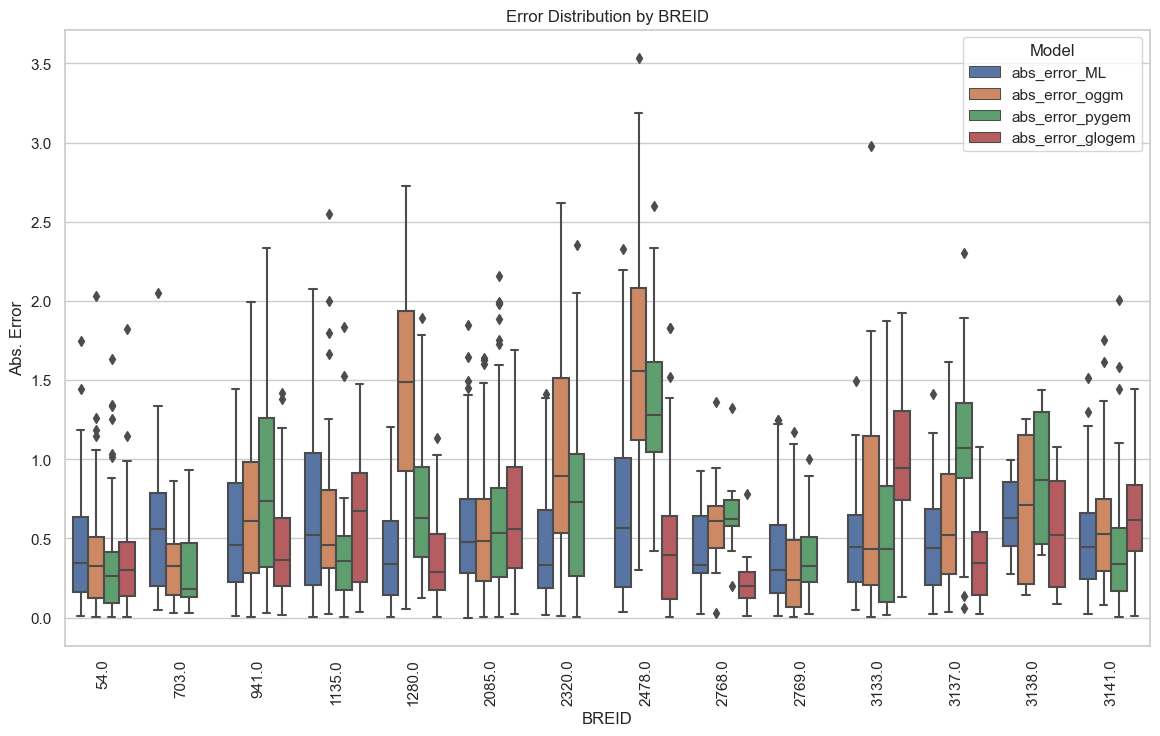

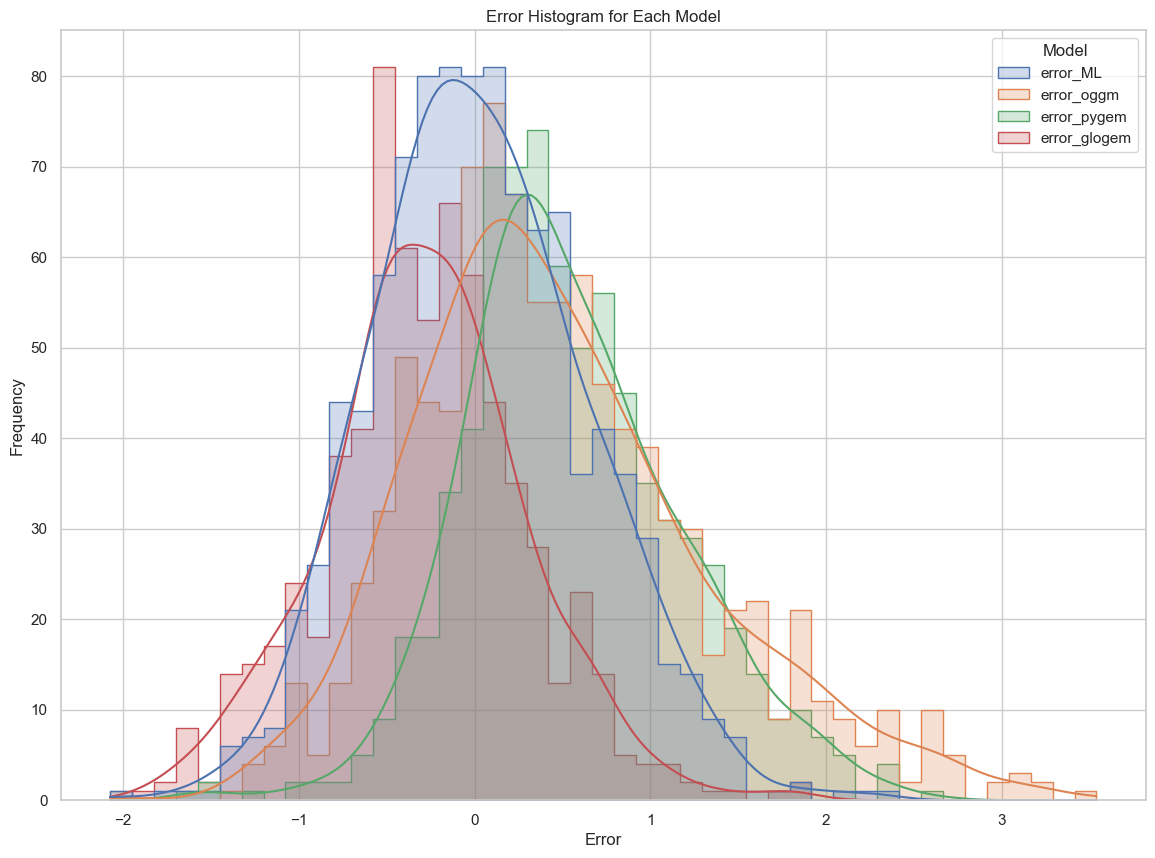

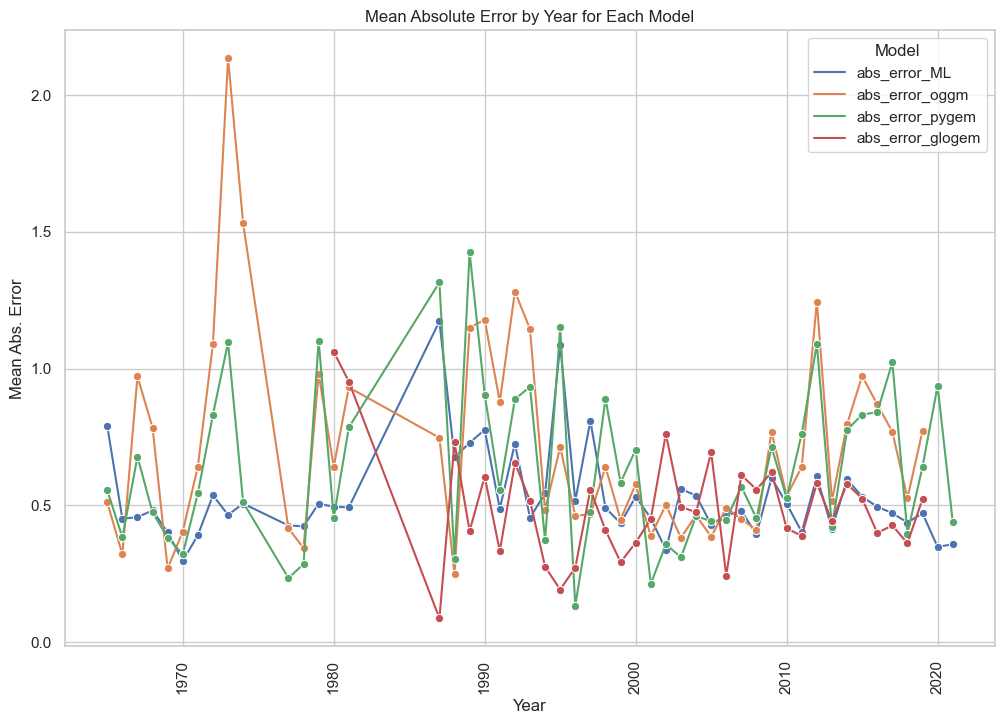

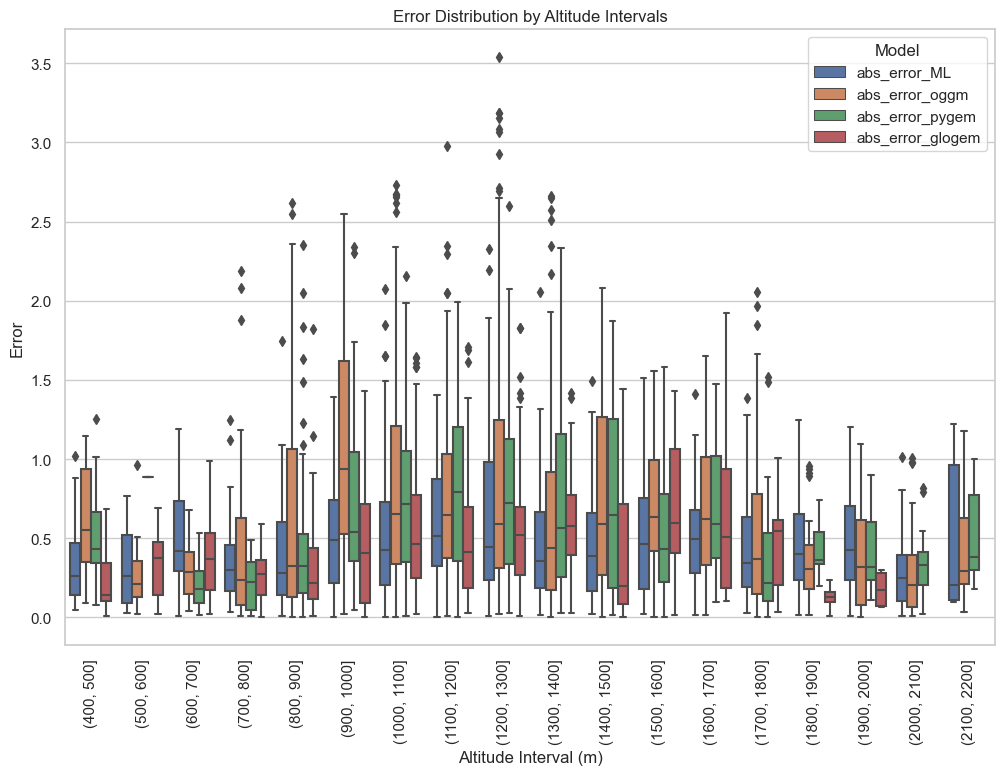

In [247]:
# Winter mass balance, all points

create_box_plots(df_test_winter, 'BREID')

create_histograms(df_test_winter)

plot_mean_absolute_error_by_year(df_test_winter, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_winter, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)